# London Housing Price Prediction Using Machine Learning Algorithms


**Acknowledgement**

The some parts of scripts used in this project are adapted from practical sessions of GEOG0115 Module taught at UCL created by Stephen Law & Thomas Keel.

In [5]:
#importing necessary packages for this project

##data managament

import numpy as np #for numeric calculations with more complex data structures
import pandas as pd #for data importing, wrangling and cleaning

##data visualisation

import matplotlib.pyplot as plt #for plots and data visualisation
import seaborn as sns #for plots and data visualisation
import geopandas as gpd #for geospatial data management and mapping
import contextily as ctx #for retrieving basemaps from the internet
import scipy.stats #shapiro-wilk test for normality
from scipy.stats import norm #for normal distribution curve


##feature engineering

from scipy.stats import skew #check for skewness
from sklearn.preprocessing import StandardScaler #standard scaler of variables

##analysis

from sklearn.model_selection import train_test_split #splitting dataset into train and split before modelling
from sklearn import linear_model #linear regression model
from sklearn.decomposition import PCA #principal component analysis
from sklearn import metrics #metics
from sklearn.metrics import mean_squared_error,r2_score, mean_absolute_error #metrics
from sklearn.neighbors import KNeighborsRegressor #K nearest Neighbour Regressor
from sklearn.ensemble import RandomForestRegressor #Random Forest Regression
from sklearn.linear_model import Lasso #lasso regression
from sklearn.model_selection import cross_validate #cross validation
from sklearn.model_selection import GridSearchCV #grid search
from sklearn.model_selection import RandomizedSearchCV # randomized search
from sklearn.model_selection import KFold #kfold
from sklearn.feature_selection import RFE #rfe

##ignore warnings

import warnings
warnings.filterwarnings(action='ignore')

## 1. Data Importing

**Datasets**

**The Main Dataset**

* London Property - the main dataset
* London Property Location -the dataset for geolocating the main dataset
    
**Datasets used for enrichment and new variables**

* Indices of Deprivation
* Public Transport Accessibility Levels
* Lower Layer Super Output Area

### 1.1. London Housing Dataset

This dataset is filtered version of House Price per Square Metre in England and Wales created by Bin Chi, Adam Dennett, Thomas Oléron-Evans and Robin Morphet (all UCL).The dataset retrieved from https://data.london.gov.uk/dataset/house-price-per-square-metre-in-england-and-wales is created through complex address-based matching between the Land Registry’s Price Paid Data (LR-PPD) and property size information from the Domestic Energy Performance Certificates (EPC) data published by the Department for Levelling Up, Housing and Communities (DLUHC, formerly MHCLG) as indicated in London Datastore website in 2022. The dataset containing eastings and northings will be imported in section 1.2.


* 'Code' : ID of borough in which the property is located.
* 'Area_name' : Name of the borough in which the property is located.
* 'year' : Year when the sale was completed.
* 'dateoftransfer': Date when the sale was completed.
* 'propertytype' : Indicates the type of house: D = Detached, S = Semi-Detached, T = Terraced, F = Flats/Maisonettes. 
* 'duration' : Tenure of dwelling (freehold/leasehold)
* 'price' : Price paid for the property.
* 'postcode': The property's postal code.
* 'lad21cd' : The 2021 local authority district code 
* 'transactionid' : Transaction unique identifier 
* 'id' : A unique identifier in Domestic EPCs
* 'tfarea' : The total floor area of the dwelling
* 'numberrooms' : The number of rooms in dwelling
* 'classt' : address matching ratio
* 'CURRENT_ENERGY_EFFICIENCY' : Current energy efficiency rating
* 'POTENTIAL_ENERGY_EFFICIENCY' : Potential energy efficiency rating
* 'CONSTRUCTION_AGE_BAND' : approximate age of the property when constructed.

In [6]:
#importing our London property dataset as a csv file by means of pandas package
#lowercase all column names
#drop unneccesary columns 
#change name of "code" and "area_name" not to confuse in the later - LSOA level data will also be joined later

london_property = pd.read_csv("Data/London Property Data/London_property.csv").rename(columns=str.capitalize).drop(["Id","Year","Dateoftransfer", "Transactionid","Lad21cd","Classt"], axis = 1).rename(columns = {"Code":"BoroughCode","Area_name":"BoroughName","Propertytype":"Property Type","Numberrooms":"Number of Rooms","Current_energy_efficiency":"Current Energy Efficiency","Potential_energy_efficiency":"Potential Energy Efficiency","Construction_age_band":"Construction Age Band","Tfarea":"Total Floor Area"})


#have a look at the first few rows of property dataset

london_property.head()

BoroughCode     BoroughName Property Type Duration    Price Postcode  \
0   E09000001  City of London             F        L   746000  EC1A4HU   
1   E09000001  City of London             F        L   649950  EC1A7AB   
2   E09000001  City of London             F        L  1485000  EC1A7BB   
3   E09000001  City of London             F        L  1500000  EC1A7BD   
4   E09000001  City of London             F        L  1624500  EC1A7BF   

   Total Floor Area  Number of Rooms  Current Energy Efficiency  \
0              61.0              3.0                         77   
1              48.0              3.0                         77   
2             117.0              NaN                         83   
3              99.0              NaN                         88   
4              83.0              NaN                         85   

   Potential Energy Efficiency           Construction Age Band  
0                           83    England and Wales: 1996-2002  
1                           82  England and Wales: before 1900  
2                           83                        NO DATA!  
3                           88                        NO DATA!  
4                           85                        NO DATA!

In [7]:
london_property.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60569 entries, 0 to 60568
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   BoroughCode                  60569 non-null  object 
 1   BoroughName                  60569 non-null  object 
 2   Property Type                60569 non-null  object 
 3   Duration                     60569 non-null  object 
 4   Price                        60569 non-null  int64  
 5   Postcode                     60569 non-null  object 
 6   Total Floor Area             60569 non-null  float64
 7   Number of Rooms              51338 non-null  float64
 8   Current Energy Efficiency    60569 non-null  int64  
 9   Potential Energy Efficiency  60569 non-null  int64  
 10  Construction Age Band        60513 non-null  object 
dtypes: float64(2), int64(3), object(6)
memory usage: 5.1+ MB


### 1.2. London Housing Location Dataset

This dataset is address-matching version of the housing dataset created by Bin Chi, Adam Dennett, Thomas Oléron-Evans and Robin Morphet (all UCL) and retrieved from https://data.london.gov.uk/dataset/house-price-per-square-metre-in-england-and-wales 

The dataset is ```london_properties_loc.csv``` which contains:
* 'Postcode': The property's postal code.
* 'Eastings': easting of property
* 'Northings': northing of property

This data is going to be used to geolocate our first dataset.

In [8]:
#importing the postcode coordinates

london_loc = pd.read_csv("Data/London Property Data/London_loc.csv")

#have a look at the first few rows of the dataset

london_loc.head()


Postcode  Eastings  Northings
0  EC1A4HU    532118     181647
1  EC1A7AB    532008     181777
2  EC1A7BB    532022     181628
3  EC1A7BD    532023     181707
4  EC1A7BF    531998     181655

In [9]:
london_loc.shape

(39653, 3)

###  1.3. Indices of Deprivation Data


The dataset contains official measures of deprivation from the Ministry for Housing, Communities and Local Government. 
It is created by Greater London Authority and licensed under the Open Government Licence v3.0. It can be retrieved from https://data.london.gov.uk/dataset/indices-of-deprivation

In [10]:
#importing deprivation excel file
deprivation = pd.read_excel("Data/Deprivation Data/ID 2019 for London.xlsx",sheet_name= "IMD 2019")

# Installing openpyxl for read_excel is required

deprivation.head()

LSOA code (2011)     LSOA name (2011) Local Authority District code (2019)  \
0        E01000001  City of London 001A                            E09000001   
1        E01000002  City of London 001B                            E09000001   
2        E01000003  City of London 001C                            E09000001   
3        E01000005  City of London 001E                            E09000001   
4        E01032739  City of London 001F                            E09000001   

  Local Authority District name (2019)  \
0                       City of London   
1                       City of London   
2                       City of London   
3                       City of London   
4                       City of London   

   Index of Multiple Deprivation (IMD) Score  \
0                                      6.208   
1                                      5.143   
2                                     19.402   
3                                     28.652   
4                                     13.584   

   Index of Multiple Deprivation (IMD) Rank (where 1 is most deprived)  \
0                                              29199                     
1                                              30379                     
2                                              14915                     
3                                               8678                     
4                                              20391                     

   Index of Multiple Deprivation (IMD) Decile (where 1 is most deprived 10% of LSOAs)  \
0                                                  9                                    
1                                                 10                                    
2                                                  5                                    
3                                                  3                                    
4                                                  7                                    

   Income Score (rate)  Income Rank (where 1 is most deprived)  \
0                0.007                                   32831   
1                0.034                                   29901   
2                0.086                                   18510   
3                0.211                                    6029   
4                0.014                                   32638   

   Income Decile (where 1 is most deprived 10% of LSOAs)  ...  \
0                                                 10      ...   
1                                                 10      ...   
2                                                  6      ...   
3                                                  2      ...   
4                                                 10      ...   

   Health Deprivation and Disability Decile (where 1 is most deprived 10% of LSOAs)  \
0                                                 10                                  
1                                                 10                                  
2                                                  6                                  
3                                                  6                                  
4                                                  8                                  

   Crime Score  Crime Rank (where 1 is most deprived)  \
0       -2.012                                  32662   
1       -2.343                                  32789   
2       -1.032                                  29363   
3       -1.317                                  31059   
4       -1.560                                  31947   

   Crime Decile (where 1 is most deprived 10% of LSOAs)  \
0                                                 10      
1                                                 10      
2                                                  9      
3                                                 10      
4                                                 

In [11]:
#look at columns and their types

deprivation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4835 entries, 0 to 4834
Data columns (total 28 columns):
 #   Column                                                                              Non-Null Count  Dtype  
---  ------                                                                              --------------  -----  
 0   LSOA code (2011)                                                                    4835 non-null   object 
 1   LSOA name (2011)                                                                    4835 non-null   object 
 2   Local Authority District code (2019)                                                4835 non-null   object 
 3   Local Authority District name (2019)                                                4835 non-null   object 
 4   Index of Multiple Deprivation (IMD) Score                                           4835 non-null   float64
 5   Index of Multiple Deprivation (IMD) Rank (where 1 is most deprived)                 4835 non-null

### 1.4. Public Transport Accessibility Levels (PTAL)

Public Transport Accessibility Levels dataset is created by Tranport for London (TFL) licensed under the Open Government Licence v2.0. As stated in London Datastore in 2015, PTALS provide a thorough and accurate assessment of a point's connectivity to the public transportation system. Essentially, the technique is a tool to measure the density of the Greater London area's public transportation system. It can be retrived from https://data.london.gov.uk/dataset/public-transport-accessibility-levels

In [12]:
#importing PTAL grid value data
ptal = gpd.read_file("Data/2015  PTALs Grid Values/2015  PTALs Contours 280515.TAB").drop(["Lower", "Upper"], axis = 1).rename(columns = {"PTAL":"ptal"}).to_crs("EPSG:27700")

ptal.head()

ptal                                           geometry
0    0  MULTIPOLYGON (((554862.964 180220.108, 554880....
1   1a  MULTIPOLYGON (((551461.149 173824.073, 551344....
2   1b  MULTIPOLYGON (((545416.787 192699.693, 545458....
3    2  MULTIPOLYGON (((505136.122 184636.304, 505147....
4    3  MULTIPOLYGON (((543244.654 183669.000, 543200....

### 1.5 London Boroughs and LSOA Spatial Data

Statistical GIS Boundary Files for London is created by Greater London Authority and licensed under the Open Government Licence v2.0. It can be retrieved from https://data.london.gov.uk/dataset/statistical-gis-boundary-files-london

*Contains National Statistics data © Crown copyright and database right [2015] <br>
*Contains Ordnance Survey data © Crown copyright and database right [2015]*

In [13]:
#importing London borough shapefile
boroughs = gpd.read_file("Data/statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp").drop(["HECTARES","NONLD_AREA","ONS_INNER","SUB_2009","SUB_2006"], axis = 1).rename(columns={"GSS_CODE":"BoroughCode"}).to_crs("EPSG:27700")

boroughs.head()

NAME BoroughCode  \
0  Kingston upon Thames   E09000021   
1               Croydon   E09000008   
2               Bromley   E09000006   
3              Hounslow   E09000018   
4                Ealing   E09000009   

                                            geometry  
0  POLYGON ((516401.600 160201.800, 516407.300 16...  
1  POLYGON ((535009.200 159504.700, 535005.500 15...  
2  POLYGON ((540373.600 157530.400, 540361.200 15...  
3  POLYGON ((521975.800 178100.000, 521967.700 17...  
4  POLYGON ((510253.500 182881.600, 510249.900 18...

**LSOA Shapefile**

In [14]:
#importing LSOA shapefile
lsoa = gpd.read_file("Data/statistical-gis-boundaries-london/ESRI/LSOA_2011_London_gen_MHW.shp").rename(columns=str.lower).drop(["lsoa11nm","msoa11cd","msoa11nm","lad11cd","lad11nm","rgn11cd","rgn11nm","usualres","hholdres","hholds", "comestres","popden","avhholdsz"], axis = 1).to_crs("EPSG:27700")

lsoa.head()

lsoa11cd                                           geometry
0  E01000001  POLYGON ((532105.092 182011.230, 532162.491 18...
1  E01000002  POLYGON ((532746.813 181786.891, 532671.688 18...
2  E01000003  POLYGON ((532135.145 182198.119, 532158.250 18...
3  E01000005  POLYGON ((533807.946 180767.770, 533649.063 18...
4  E01000006  POLYGON ((545122.049 184314.931, 545271.917 18...

## 2. Data Wrangling and Exploration

We have already started to wrangle the data during importing them. Let's continue with more advanced data wrangling.

### 2.1. London Housing Data Wrangling

In [15]:
#have a look at the few rows of property dataset

london_property.head()

BoroughCode     BoroughName Property Type Duration    Price Postcode  \
0   E09000001  City of London             F        L   746000  EC1A4HU   
1   E09000001  City of London             F        L   649950  EC1A7AB   
2   E09000001  City of London             F        L  1485000  EC1A7BB   
3   E09000001  City of London             F        L  1500000  EC1A7BD   
4   E09000001  City of London             F        L  1624500  EC1A7BF   

   Total Floor Area  Number of Rooms  Current Energy Efficiency  \
0              61.0              3.0                         77   
1              48.0              3.0                         77   
2             117.0              NaN                         83   
3              99.0              NaN                         88   
4              83.0              NaN                         85   

   Potential Energy Efficiency           Construction Age Band  
0                           83    England and Wales: 1996-2002  
1                           82  England and Wales: before 1900  
2                           83                        NO DATA!  
3                           88                        NO DATA!  
4                           85                        NO DATA!

At a glance, it can be easily seen that there are some missing values in the number of rooms and construction age band columns.

In [16]:
#number of rows and columns in property dataset

london_property.shape

(60569, 11)

London property dataset has 60569 rows and 17 columns.

In [17]:
#understanding our columns' types

london_property.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60569 entries, 0 to 60568
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   BoroughCode                  60569 non-null  object 
 1   BoroughName                  60569 non-null  object 
 2   Property Type                60569 non-null  object 
 3   Duration                     60569 non-null  object 
 4   Price                        60569 non-null  int64  
 5   Postcode                     60569 non-null  object 
 6   Total Floor Area             60569 non-null  float64
 7   Number of Rooms              51338 non-null  float64
 8   Current Energy Efficiency    60569 non-null  int64  
 9   Potential Energy Efficiency  60569 non-null  int64  
 10  Construction Age Band        60513 non-null  object 
dtypes: float64(2), int64(3), object(6)
memory usage: 5.1+ MB


#### 2.1.1 Descriptive Statistics of London Housing Dataset

In [18]:
#have a look at descriptive statistics of property data

london_property.describe().T

count           mean            std  min  \
Price                        60569.0  658321.237250  725973.528023  1.0   
Total Floor Area             60569.0      93.411986      53.077365  0.0   
Number of Rooms              51338.0       4.388250       1.812658  1.0   
Current Energy Efficiency    60569.0      65.267678      12.863690  1.0   
Potential Energy Efficiency  60569.0      79.673348       7.276830  1.0   

                                  25%       50%        75%         max  
Price                        372000.0  495000.0  710000.00  35500000.0  
Total Floor Area                 62.0      81.0     109.92      1930.0  
Number of Rooms                   3.0       4.0       5.00        60.0  
Current Energy Efficiency        58.0      65.0      73.00       109.0  
Potential Energy Efficiency      77.0      81.0      85.00       123.0

The minumum price in the dataset is 1, which is inarguably a mistake. Similarly, total area cannot be zero.

#### 2.1.2 Removing Incorrect Rows

In [19]:
#checking for duplicates
london_property.duplicated().value_counts()

False    60205
True       364
dtype: int64

In [20]:
london_property.drop_duplicates(inplace=True)

In [21]:
london_property.shape

(60205, 11)

In [22]:
#removing the row where price is 1

london_property[london_property["Price"]==1].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1 entries, 30155 to 30155
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   BoroughCode                  1 non-null      object 
 1   BoroughName                  1 non-null      object 
 2   Property Type                1 non-null      object 
 3   Duration                     1 non-null      object 
 4   Price                        1 non-null      int64  
 5   Postcode                     1 non-null      object 
 6   Total Floor Area             1 non-null      float64
 7   Number of Rooms              1 non-null      float64
 8   Current Energy Efficiency    1 non-null      int64  
 9   Potential Energy Efficiency  1 non-null      int64  
 10  Construction Age Band        1 non-null      object 
dtypes: float64(2), int64(3), object(6)
memory usage: 96.0+ bytes


In [23]:
london_property.drop(london_property[london_property["Price"]==1.0].index,inplace = True)

In [24]:
#finding rows where total area is 0

london_property[london_property["Total Floor Area"]==0].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21 entries, 784 to 58206
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   BoroughCode                  21 non-null     object 
 1   BoroughName                  21 non-null     object 
 2   Property Type                21 non-null     object 
 3   Duration                     21 non-null     object 
 4   Price                        21 non-null     int64  
 5   Postcode                     21 non-null     object 
 6   Total Floor Area             21 non-null     float64
 7   Number of Rooms              0 non-null      float64
 8   Current Energy Efficiency    21 non-null     int64  
 9   Potential Energy Efficiency  21 non-null     int64  
 10  Construction Age Band        21 non-null     object 
dtypes: float64(2), int64(3), object(6)
memory usage: 2.0+ KB


There are 21 rows where total area is zero. In those rows, the values of number of rooms and construction age band columns is also null. Therefore, we can comfortably drop those rows.

In [25]:
london_property.drop(london_property[london_property["Total Floor Area"]==0].index,inplace = True)

In [26]:
london_property.shape

(60183, 11)

#### 2.1.3 Dealing with Missing Data


In [27]:
#understanding missing values in property data

london_property.shape

(60183, 11)

In [28]:
london_property["Construction Age Band"].isnull().value_counts()

False    60127
True        56
Name: Construction Age Band, dtype: int64

Construction Age Band column has 56 NaN values as well as other missing values (NO DATA! and INVALID!).

In [29]:
#convert NO DATA! and INVALID! values into NaN

london_property.replace('NO DATA!',np.NaN, inplace =True)
london_property.replace('INVALID!',np.NaN, inplace =True)


In [30]:
#number of missing values in each column

london_property.isnull().sum()


BoroughCode                       0
BoroughName                       0
Property Type                     0
Duration                          0
Price                             0
Postcode                          0
Total Floor Area                  0
Number of Rooms                8870
Current Energy Efficiency         0
Potential Energy Efficiency       0
Construction Age Band          9025
dtype: int64

Most of the rows in numberrooms and construction age band columns is null simultaneously. Therefore, we can drop those missing values.

In [31]:
#dropping missing values 

london_property = london_property.dropna()

london_property.shape

(51148, 11)

We dropped 8979 rows in total.

#### 2.1.4 Converting London Housing data into spatial point data


In [32]:
#join the dataset with the postcode column

london_property_loc = london_property.merge(london_loc, on = "Postcode", how= "left" )

In [33]:
#convert df into gdf using easting and northings 
#project the gdf into British National Grid (27700)

london_property_gdf = gpd.GeoDataFrame(
    london_property_loc, 
    geometry=gpd.points_from_xy(london_property_loc.Eastings, 
                                      london_property_loc.Northings)).set_crs(epsg=27700)

In [34]:
london_property_gdf.head()

BoroughCode     BoroughName Property Type Duration    Price Postcode  \
0   E09000001  City of London             F        L   746000  EC1A4HU   
1   E09000001  City of London             F        L   649950  EC1A7AB   
2   E09000001  City of London             F        L   800000  EC1A7BT   
3   E09000001  City of London             F        L   550000  EC1A7ES   
4   E09000001  City of London             T        F  1850000  EC1A7JQ   

   Total Floor Area  Number of Rooms  Current Energy Efficiency  \
0             61.00              3.0                         77   
1             48.00              3.0                         77   
2             69.00              3.0                         79   
3             48.00              2.0                         78   
4            114.34              5.0                         63   

   Potential Energy Efficiency           Construction Age Band  Eastings  \
0                           83    England and Wales: 1996-2002    532118   
1                           82  England and Wales: before 1900    532008   
2                           79    England and Wales: 1991-1995    532044   
3                           86    England and Wales: 1996-2002    532051   
4                           65    England and Wales: 1983-1990    531940   

   Northings                       geometry  
0     181647  POINT (532118.000 181647.000)  
1     181777  POINT (532008.000 181777.000)  
2     181488  POINT (532044.000 181488.000)  
3     181664  POINT (532051.000 181664.000)  
4     181734  POINT (531940.000 181734.000)

In [35]:
london_property_gdf.crs

<Derived Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.0, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

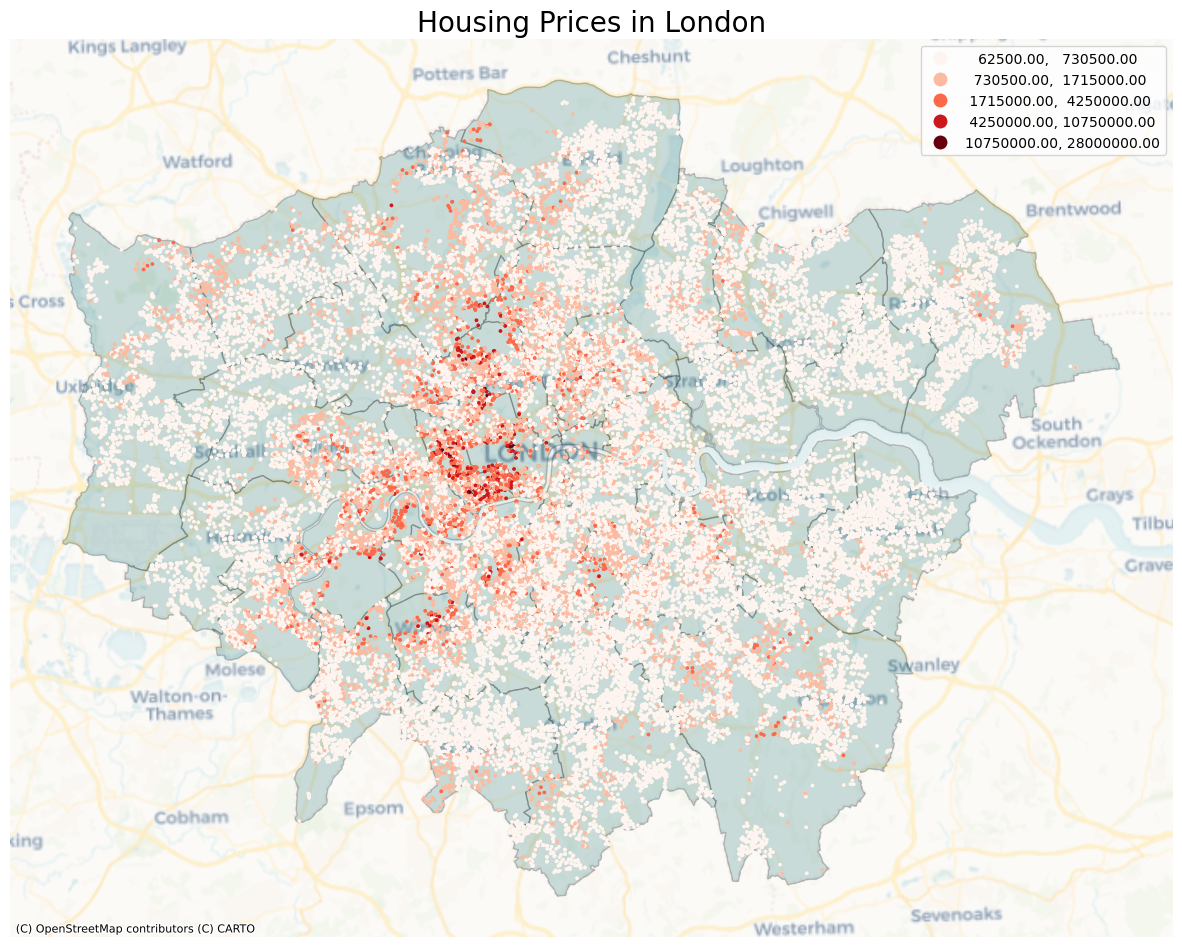

In [36]:
#mapping housing price distribution in London without dealing with outliers

fig, ax = plt.subplots(figsize=(15, 15))


ax.set_aspect('equal')


boroughs.plot(ax=ax, color='#00615f', edgecolor='black',alpha = 0.2)


london_property_gdf.plot(ax=ax,marker='o', markersize=3,column="Price",scheme = "NaturalBreaks", cmap="Reds",legend=True)



# this adds the basemap
ctx.add_basemap(ax, crs=london_property_gdf.crs, alpha=0.6, source=ctx.providers.CartoDB.Voyager, zoom =10)

# this sets the title
ax.set_title("Housing Prices in London",fontsize= 20)

# this removes the axis
ax.set_axis_off()

### 2.2. Deprivation Data Wrangling

In [37]:
#choose only necessary columns: LSOA code and deprivation score

deprivation = pd.read_excel("Data/Deprivation Data/ID 2019 for London.xlsx",sheet_name= "IMD 2019",usecols = ["LSOA code (2011)","Index of Multiple Deprivation (IMD) Score"]).rename(columns = {"LSOA code (2011)":"LSOA Code", "Index of Multiple Deprivation (IMD) Score":"Index of Deprivation Score"})


deprivation.head()

LSOA Code  Index of Deprivation Score
0  E01000001                       6.208
1  E01000002                       5.143
2  E01000003                      19.402
3  E01000005                      28.652
4  E01032739                      13.584

### 2.3. PTAL Data Wrangling

In [38]:
#ptal values are 1a, 1b, 2, 3, 4, 5 and 6 consecutively. This is an ordinal data even if it is string. Convert these values into number to make it compatible with analysis

ptal['PTAL']= ptal['ptal'].map({"0":0,'1a':1,'1b':'2',"2":3,"3":4,"4":5,"5":6,"6a":7,"6b":8})

ptal['PTAL'] = ptal['PTAL'].astype(int)

ptal2 = ptal.drop("ptal", axis=1)

ptal.head()

ptal                                           geometry  PTAL
0    0  MULTIPOLYGON (((554862.964 180220.108, 554880....     0
1   1a  MULTIPOLYGON (((551461.149 173824.073, 551344....     1
2   1b  MULTIPOLYGON (((545416.787 192699.693, 545458....     2
3    2  MULTIPOLYGON (((505136.122 184636.304, 505147....     3
4    3  MULTIPOLYGON (((543244.654 183669.000, 543200....     4

### 2.4. Exploring Outliers of London Housing

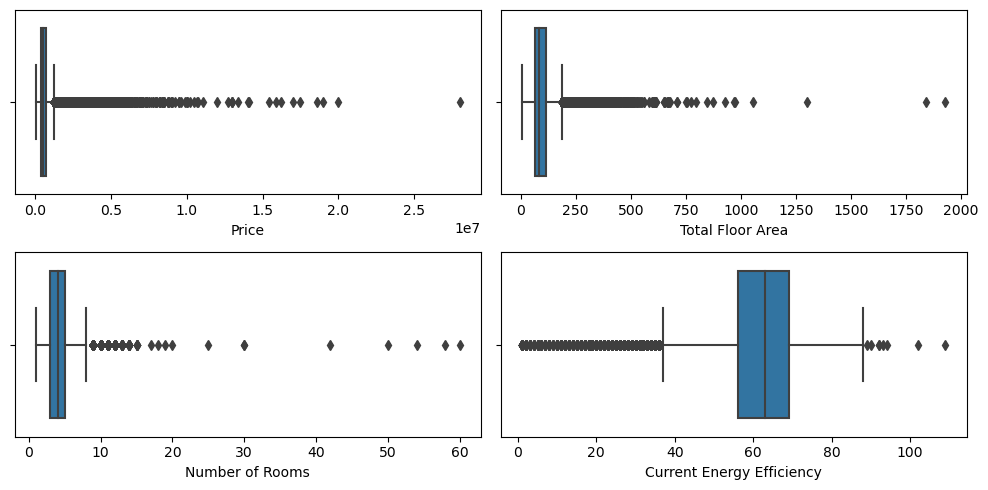

In [39]:
#have a look at outliers of price, total floor area, number of rooms and current energy efficiency

fig, axs = plt.subplots(2,2, figsize = (10,5))
plt1 = sns.boxplot(london_property_gdf['Price'], ax = axs[0,0])
plt2 = sns.boxplot(london_property_gdf['Total Floor Area'], ax = axs[0,1])
plt3 = sns.boxplot(london_property_gdf['Number of Rooms'], ax = axs[1,0])
plt4 = sns.boxplot(london_property_gdf['Current Energy Efficiency'], ax = axs[1,1])

plt.tight_layout()

In [40]:
#look at how many houses have more than ten rooms
(london_property_gdf["Number of Rooms"]<10).value_counts()



True     50667
False      481
Name: Number of Rooms, dtype: int64

In [41]:
#look at how many houses are more spacious than 400 m2


(london_property_gdf["Total Floor Area"] <=400).value_counts()

True     51017
False      131
Name: Total Floor Area, dtype: int64

In [42]:
#remove extreme values of total floor area and number of rooms


london_property_gdf = london_property_gdf[(london_property_gdf["Total Floor Area"] <=400) & (london_property_gdf["Number of Rooms"] < 10)]


In [43]:

#remove extreme values of current energy efficiencies,which are lower than 10 and greater than 1000
london_property_gdf = london_property_gdf[(london_property_gdf["Current Energy Efficiency"] > 9) & (london_property_gdf["Current Energy Efficiency"] < 101)]

london_property.describe().T

count           mean            std      min  \
Price                        51148.0  652958.247087  661595.524609  62500.0   
Total Floor Area             51148.0      95.860098      52.892479      5.0   
Number of Rooms              51148.0       4.389966       1.811755      1.0   
Current Energy Efficiency    51148.0      61.954094      10.929799      1.0   
Potential Energy Efficiency  51148.0      78.889263       7.247913      1.0   

                                  25%       50%       75%         max  
Price                        370000.0  490000.0  715000.0  28000000.0  
Total Floor Area                 64.0      84.0     113.0      1930.0  
Number of Rooms                   3.0       4.0       5.0        60.0  
Current Energy Efficiency        56.0      63.0      69.0       109.0  
Potential Energy Efficiency      76.0      80.0      84.0       123.0

In [44]:
london_property_gdf.shape

(50532, 14)

In [45]:
#remove extreme values of house prices

london_property_gdf = london_property_gdf[(london_property_gdf["Price"] < 5000000)] # only a 100 observations between 5.000.000 and 14.050.000

london_property_gdf.describe().T

count           mean            std       min  \
Price                        50434.0  614817.186680  444299.017714   62500.0   
Total Floor Area             50434.0      92.950492      42.704784       5.0   
Number of Rooms              50434.0       4.313459       1.611281       1.0   
Current Energy Efficiency    50434.0      62.114605      10.590302      10.0   
Potential Energy Efficiency  50434.0      78.954753       7.175188      18.0   
Eastings                     50434.0  531286.376512   11143.086248  504105.0   
Northings                    50434.0  178821.530654    8993.437598  156844.0   

                                   25%        50%       75%        max  
Price                        370000.00  486100.50  700000.0  4975000.0  
Total Floor Area                 64.00      83.72     111.0      400.0  
Number of Rooms                   3.00       4.00       5.0        9.0  
Current Energy Efficiency        56.00      63.00      69.0       94.0  
Potential Energy Efficiency      76.00      80.00      84.0      123.0  
Eastings                     524252.00  531101.50  538799.0   559518.0  
Northings                    172007.25  178128.00  186300.0   199975.0

50434 rows will be used in analysis.

In [46]:
#calculate housing price outliers

Q1 = london_property_gdf['Price'].quantile(0.25)
Q3 = london_property_gdf['Price'].quantile(0.75)
IQR = Q3 - Q1    #IQR is interquartile range. 

#creating a data without price outliers

filter = (london_property_gdf['Price'] >= Q1 - 1.5 * IQR) & (london_property_gdf['Price'] <= Q3 + 1.5 *IQR)
london_property_without_outliers = london_property_gdf.loc[filter] 

london_property_without_outliers .info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 46431 entries, 0 to 51144
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   BoroughCode                  46431 non-null  object  
 1   BoroughName                  46431 non-null  object  
 2   Property Type                46431 non-null  object  
 3   Duration                     46431 non-null  object  
 4   Price                        46431 non-null  int64   
 5   Postcode                     46431 non-null  object  
 6   Total Floor Area             46431 non-null  float64 
 7   Number of Rooms              46431 non-null  float64 
 8   Current Energy Efficiency    46431 non-null  int64   
 9   Potential Energy Efficiency  46431 non-null  int64   
 10  Construction Age Band        46431 non-null  object  
 11  Eastings                     46431 non-null  int64   
 12  Northings                    46431 non-null  int64  

In [47]:
#calculate housing price outliers

filter1 = (london_property_gdf['Price'] <= Q1 - 1.5 * IQR) | (london_property_gdf['Price'] >= Q3 + 1.5 *IQR)

#create a gdf including only outliers

outliers = london_property_gdf[filter1 == True]

outliers.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 4017 entries, 4 to 51147
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   BoroughCode                  4017 non-null   object  
 1   BoroughName                  4017 non-null   object  
 2   Property Type                4017 non-null   object  
 3   Duration                     4017 non-null   object  
 4   Price                        4017 non-null   int64   
 5   Postcode                     4017 non-null   object  
 6   Total Floor Area             4017 non-null   float64 
 7   Number of Rooms              4017 non-null   float64 
 8   Current Energy Efficiency    4017 non-null   int64   
 9   Potential Energy Efficiency  4017 non-null   int64   
 10  Construction Age Band        4017 non-null   object  
 11  Eastings                     4017 non-null   int64   
 12  Northings                    4017 non-null   int64   

4173 outliers. Let's have a look at the distribution of outliers

In [48]:
#grouping housing price values by London boroughs 

borough_property =london_property_gdf.groupby("BoroughName")["Price"].agg(["count",min,max,"median","mean"]).reset_index()
borough_property

#finding outliers in each borough

outliers_count = outliers.groupby("BoroughCode")["Price"].agg(["count"]).reset_index()

#finding total number of housing in each borough

total_count = london_property_gdf.groupby("BoroughCode")["Price"].agg(["count"]).reset_index()

In [49]:
#join borough with grouped data

borough_out1 = pd.merge(left = boroughs, 
                                right = outliers_count).rename(columns = {"count":"outlier_count"})

borough_out = pd.merge(left = borough_out1, 
                                right = total_count).rename(columns = {"count":"total_count"})

#calculate the percentage of outliers in each borough

borough_out["per"] = (borough_out["outlier_count"] / borough_out["total_count"])*100

borough_out.head()

NAME BoroughCode  \
0  Kingston upon Thames   E09000021   
1               Croydon   E09000008   
2               Bromley   E09000006   
3              Hounslow   E09000018   
4                Ealing   E09000009   

                                            geometry  outlier_count  \
0  POLYGON ((516401.600 160201.800, 516407.300 16...             55   
1  POLYGON ((535009.200 159504.700, 535005.500 15...              7   
2  POLYGON ((540373.600 157530.400, 540361.200 15...             69   
3  POLYGON ((521975.800 178100.000, 521967.700 17...            102   
4  POLYGON ((510253.500 182881.600, 510249.900 18...             98   

   total_count       per  
0         1401  3.925767  
1         2625  0.266667  
2         3448  2.001160  
3         1252  8.146965  
4         1585  6.182965

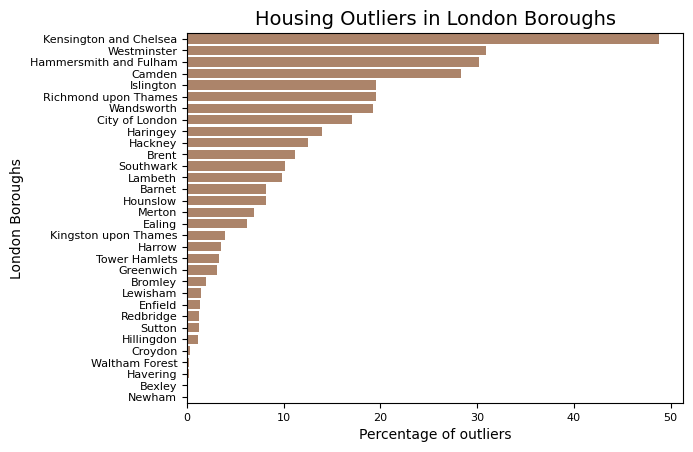

In [50]:
#creata a bar chart of outliers count in London according to boroughs

g =sns.barplot(y = "NAME", x="per", data = borough_out, color="#b7825f", order=borough_out.sort_values('per',ascending =False).NAME)

g.set_title('Housing Outliers in London Boroughs',  fontsize=14)
g.set(xlabel = 'Percentage of outliers', ylabel = 'London Boroughs')
g.tick_params(axis='both', which='major', labelsize=8)
g.ticklabel_format(style='plain', axis='x')

In Kensigton and Chelsea, 50 per cent of all housing data is outlier. This is also true for Westminster, hammersmith and Fulham and Camden. Therefore, we will not remove all outliers.

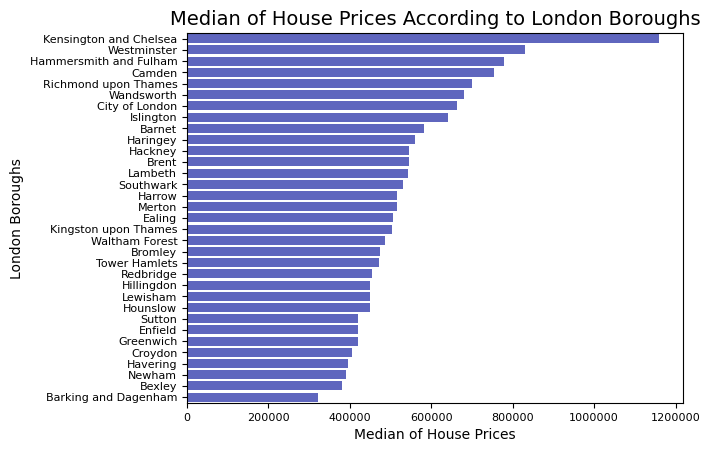

In [51]:
#creata a bar chart of median house price in London according to boroughs

g =sns.barplot(y = "BoroughName", x="median", data = borough_property, color="#4F58CE", order=borough_property.sort_values('median',ascending =False).BoroughName)

g.set_title('Median of House Prices According to London Boroughs',  fontsize=14)
g.set(xlabel = 'Median of House Prices', ylabel = 'London Boroughs')
g.tick_params(axis='both', which='major', labelsize=8)
g.ticklabel_format(style='plain', axis='x')

Distribution of Outliers

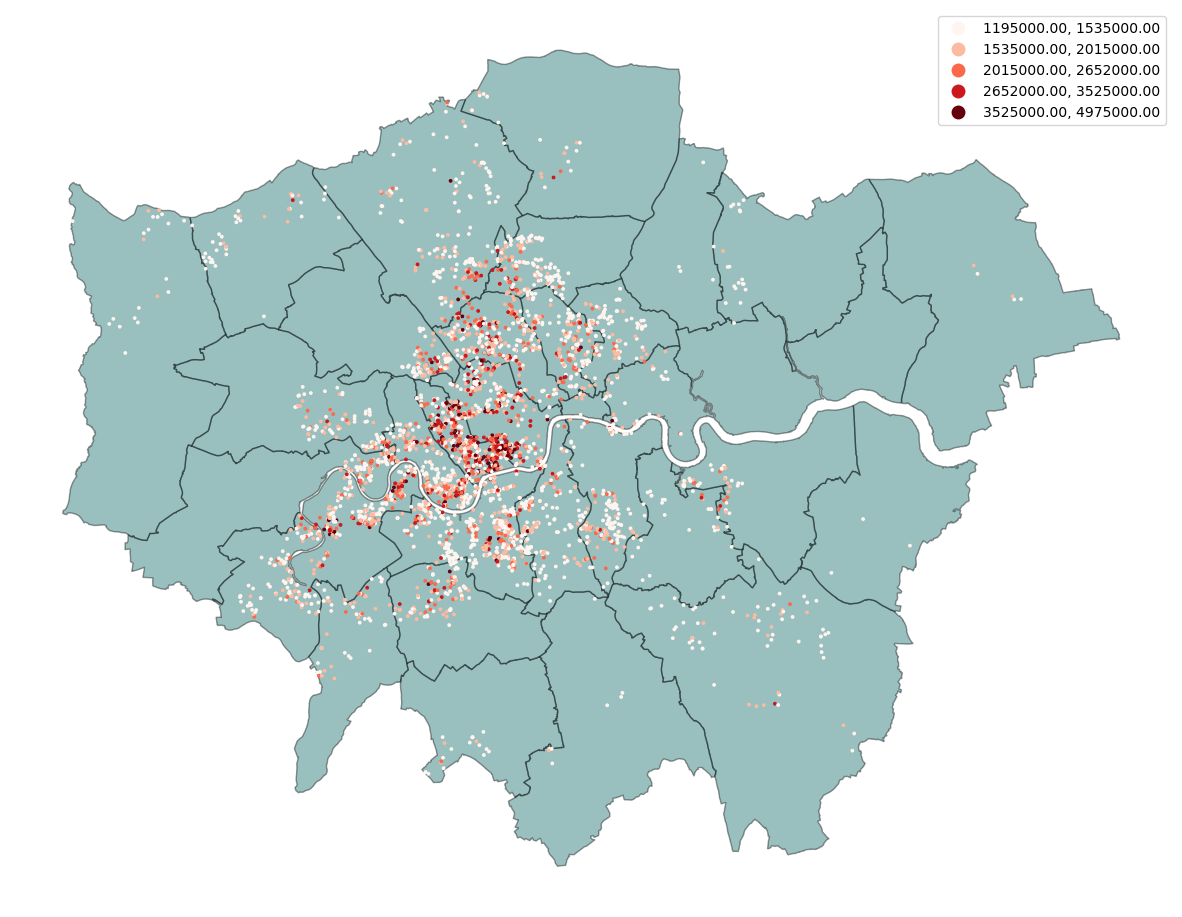

In [52]:
#mapping the disribution of outliers

fig, ax = plt.subplots(figsize=(15, 15))

#boroughs as boundaries

boroughs.plot(ax=ax, color='#00615f', edgecolor='black',alpha = 0.4)

#the distribution of points (natural break of price column)

outliers.plot(ax=ax,marker='o', markersize=3,column="Price",scheme = "NaturalBreaks", cmap="Reds",legend=True)

# this removes the axis
ax.set_axis_off()


### 2.5. The spatial distribution of housing prices in London

Figure(1500x1500) AxesSubplot(0.125,0.195806;0.775x0.598387)


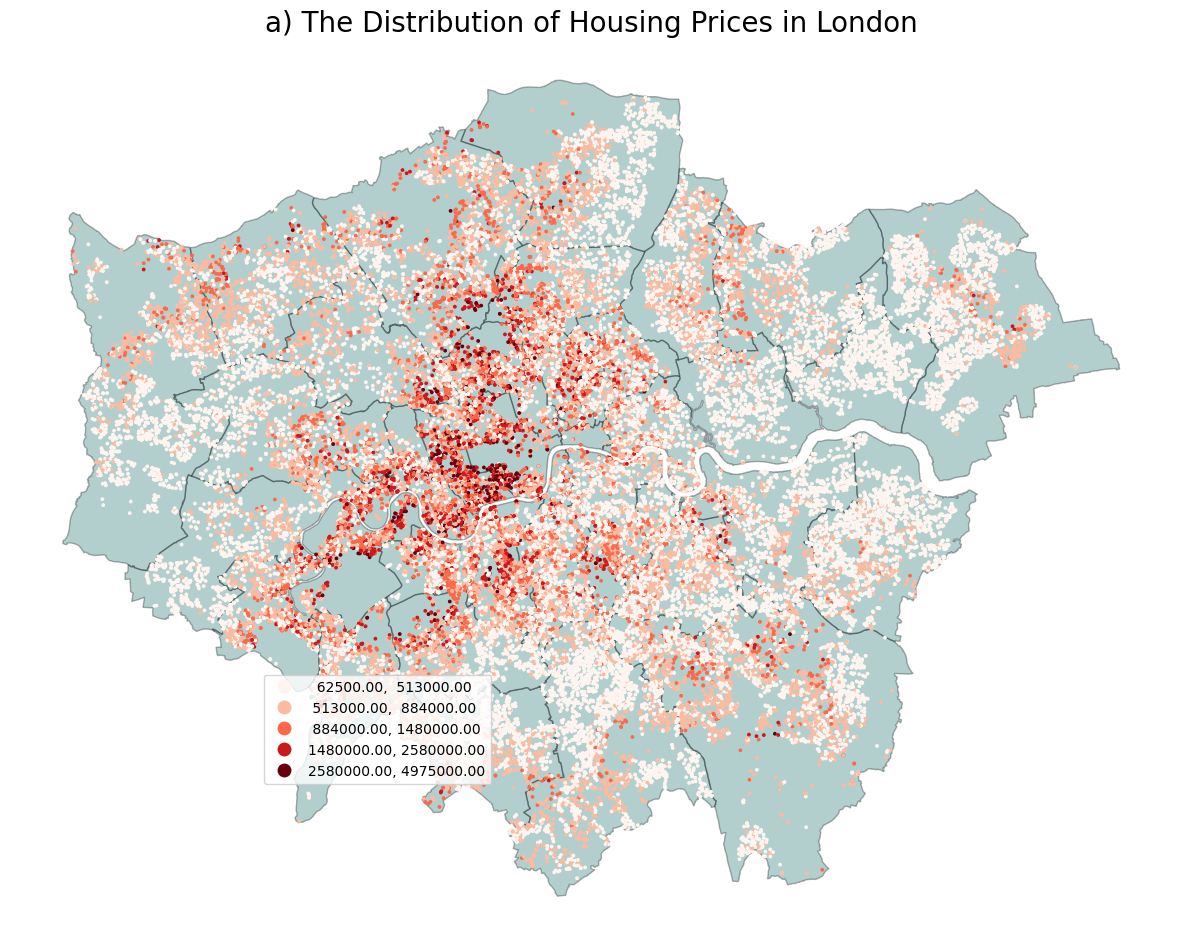

In [53]:
#mapping the distribution of housing prices

fig, ax = plt.subplots(figsize=(15, 15))

ax.set_aspect('equal')

#boroughs as boundaries

boroughs.plot(ax=ax, color='#00615f', edgecolor='black',alpha = 0.3)

#the distribution of points (natural break of price column)

london_property_gdf.plot(ax=ax,marker='o', markersize=3,column="Price",scheme = "NaturalBreaks", cmap="Reds",legend=True)

#customise legend

leg = ax.get_legend()
leg.set_bbox_to_anchor((0.42,0.3))

# this sets the title
ax.set_title("a) The Distribution of Housing Prices in London",fontsize= 20)

# this removes the axis
ax.set_axis_off()

print(fig,ax)

plt.savefig('dist1_map.png', dpi=400)

### 3. Feature Engineering

### 3.1. Deriving a new age column from construction age band column**

Converting "England and Wales: 1930-1949 " into 1930 and 1949 as two separate columns. 

1. Find the middle year (1949 + 1930)/2 = 1939.5)
2. Find the age of the property by extracting 2020 from the middle year (2020 - 1939.5 = 80.5) 

*As we can see from the date columns, we can use the year 2020 as a reference year.


In [54]:
london_property_gdf["Construction Age Band"].value_counts()

England and Wales: 1930-1949       13994
England and Wales: 1900-1929       12713
England and Wales: before 1900      6583
England and Wales: 1950-1966        5249
England and Wales: 1967-1975        3211
England and Wales: 1983-1990        2229
England and Wales: 1996-2002        1666
England and Wales: 1976-1982        1549
England and Wales: 2003-2006        1297
England and Wales: 1991-1995        1114
England and Wales: 2007 onwards      829
Name: Construction Age Band, dtype: int64

In [55]:
#splitting construction age band to get the first and second year

london_property_gdf["first_year"] = london_property_gdf["Construction Age Band"].str.split('-', n=1, expand=True)[0].str.split(': ', n=1, expand=True)[1]

london_property_gdf["last_year"] = london_property_gdf["Construction Age Band"].str.split('-', n=1, expand=True)[1]

#England and Wales: before 1900 is problematic when it comes to retrieve years
#assuming 1875 as a first year before 1900

london_property_gdf.loc[london_property_gdf["Construction Age Band"] =="England and Wales: before 1900",'first_year'] ="1875"
london_property_gdf.loc[london_property_gdf["Construction Age Band"] =="England and Wales: before 1900",'last_year'] ="1900"

#England and Wales: 2007 and onwards is problematic when it comes to retrieve years
#England and Wales: before 1900 is problematic when it comes to retrieve years
#2020 is the most recent year in the dataset 

london_property_gdf.loc[london_property_gdf["Construction Age Band"] =="England and Wales: 2007 onwards",'first_year'] ="2007"
london_property_gdf.loc[london_property_gdf["Construction Age Band"] =="England and Wales: 2007 onwards",'last_year'] ="2020"

#converting string new year columns into integer

london_property_gdf['first_year'] = london_property_gdf['first_year'].astype(int)
london_property_gdf['last_year'] = london_property_gdf['last_year'].astype(int)

#calculating the age of the property

london_property_gdf["Age"] = 2020 - ((london_property_gdf["last_year"] + london_property_gdf["first_year"])/2)

#drop first and last year columns 

london_property_gdf = london_property_gdf.drop(["first_year", "last_year","Construction Age Band","Potential Energy Efficiency","Postcode"], axis = 1)


london_property_gdf.head()

BoroughCode     BoroughName Property Type Duration    Price  \
0   E09000001  City of London             F        L   746000   
1   E09000001  City of London             F        L   649950   
2   E09000001  City of London             F        L   800000   
3   E09000001  City of London             F        L   550000   
4   E09000001  City of London             T        F  1850000   

   Total Floor Area  Number of Rooms  Current Energy Efficiency  Eastings  \
0             61.00              3.0                         77    532118   
1             48.00              3.0                         77    532008   
2             69.00              3.0                         79    532044   
3             48.00              2.0                         78    532051   
4            114.34              5.0                         63    531940   

   Northings                       geometry    Age  
0     181647  POINT (532118.000 181647.000)   21.0  
1     181777  POINT (532008.000 181777.000)  132.5  
2     181488  POINT (532044.000 181488.000)   27.0  
3     181664  POINT (532051.000 181664.000)   21.0  
4     181734  POINT (531940.000 181734.000)   33.5

**Converting categorical property type and duration columns into numeric with One Hot Encoding**

In [56]:
#onehot encoder for property type 

onehot_encode = pd.get_dummies(london_property_gdf[["Property Type"]])

london_property_gdf = pd.concat([london_property_gdf,onehot_encode],axis=1)

#adding 1 to all columns to get rid of zeros

london_property_gdf["Property Type S"] = london_property_gdf["Property Type_S"] + 1

london_property_gdf["Property Type D"] = london_property_gdf["Property Type_D"] + 1

london_property_gdf["Property Type T"] = london_property_gdf["Property Type_T"] + 1

london_property_gdf["Property Type F"] = london_property_gdf["Property Type_F"] + 1


#remove unnecessary colums

london_property_gdf= london_property_gdf.drop(["Property Type","Property Type_S","Property Type_T","Property Type_D", "Property Type_F","Duration"], axis = 1)


london_property_gdf.head()


BoroughCode     BoroughName    Price  Total Floor Area  Number of Rooms  \
0   E09000001  City of London   746000             61.00              3.0   
1   E09000001  City of London   649950             48.00              3.0   
2   E09000001  City of London   800000             69.00              3.0   
3   E09000001  City of London   550000             48.00              2.0   
4   E09000001  City of London  1850000            114.34              5.0   

   Current Energy Efficiency  Eastings  Northings  \
0                         77    532118     181647   
1                         77    532008     181777   
2                         79    532044     181488   
3                         78    532051     181664   
4                         63    531940     181734   

                        geometry    Age  Property Type S  Property Type D  \
0  POINT (532118.000 181647.000)   21.0                1                1   
1  POINT (532008.000 181777.000)  132.5                1                1   
2  POINT (532044.000 181488.000)   27.0                1                1   
3  POINT (532051.000 181664.000)   21.0                1                1   
4  POINT (531940.000 181734.000)   33.5                1                1   

   Property Type T  Property Type F  
0                1                2  
1                1                2  
2                1                2  
3                1                2  
4                2                1

### 3.2. Joining Spatial London Housing Data with deprivation data

*The code below was adapted from one of the training by Leah Wasser and Jenny Palomino in Earth Data Science website.<br>
(Lesson 5. How to Join Attributes From One Shapefile to Another in Open Source Python Using Geopandas: GIS in Python) <br>
https://www.earthdatascience.org/courses/use-data-open-source-python/intro-vector-data-python/vector-data-processing/spatial-joins-in-python-geopandas-shapely

In [57]:
#joining
london_property_gdf1= gpd.sjoin(london_property_gdf,
                         lsoa, 
                         how="inner", 
                         op='intersects').drop(['index_right'], axis=1)

london_property_gdf1.head()

BoroughCode     BoroughName    Price  Total Floor Area  Number of Rooms  \
0    E09000001  City of London   746000             61.00              3.0   
2    E09000001  City of London   800000             69.00              3.0   
18   E09000001  City of London  1680000            116.00              3.0   
19   E09000001  City of London   640000             58.00              2.0   
20   E09000001  City of London   645000             78.84              2.0   

    Current Energy Efficiency  Eastings  Northings  \
0                          77    532118     181647   
2                          79    532044     181488   
18                         50    532243     181682   
19                         50    532200     181730   
20                         77    532160     181770   

                         geometry   Age  Property Type S  Property Type D  \
0   POINT (532118.000 181647.000)  21.0                1                1   
2   POINT (532044.000 181488.000)  27.0                1                1   
18  POINT (532243.000 181682.000)  49.0                1                1   
19  POINT (532200.000 181730.000)  49.0                1                1   
20  POINT (532160.000 181770.000)  49.0                1                1   

    Property Type T  Property Type F   lsoa11cd  
0                 1                2  E01000001  
2                 1                2  E01000001  
18                1                2  E01000001  
19                1                2  E01000001  
20                1                2  E01000001

In [58]:
london_property_gdf2 = pd.merge(left = london_property_gdf1, 
                                right = deprivation, 
                                left_on='lsoa11cd',
                                right_on='LSOA Code')

london_property_gdf2.head()

BoroughCode     BoroughName    Price  Total Floor Area  Number of Rooms  \
0   E09000001  City of London   746000             61.00              3.0   
1   E09000001  City of London   800000             69.00              3.0   
2   E09000001  City of London  1680000            116.00              3.0   
3   E09000001  City of London   640000             58.00              2.0   
4   E09000001  City of London   645000             78.84              2.0   

   Current Energy Efficiency  Eastings  Northings  \
0                         77    532118     181647   
1                         79    532044     181488   
2                         50    532243     181682   
3                         50    532200     181730   
4                         77    532160     181770   

                        geometry   Age  Property Type S  Property Type D  \
0  POINT (532118.000 181647.000)  21.0                1                1   
1  POINT (532044.000 181488.000)  27.0                1                1   
2  POINT (532243.000 181682.000)  49.0                1                1   
3  POINT (532200.000 181730.000)  49.0                1                1   
4  POINT (532160.000 181770.000)  49.0                1                1   

   Property Type T  Property Type F   lsoa11cd  LSOA Code  \
0                1                2  E01000001  E01000001   
1                1                2  E01000001  E01000001   
2                1                2  E01000001  E01000001   
3                1                2  E01000001  E01000001   
4                1                2  E01000001  E01000001   

   Index of Deprivation Score  
0                       6.208  
1                       6.208  
2                       6.208  
3                       6.208  
4                       6.208

Housing Price Distribution at LSOA Level

In [59]:
#grouping housing prices by LSOA to get median housing prices for each LSOA in London

lsoa_property =london_property_gdf2.groupby("LSOA Code")["Price"].agg(["median"]).reset_index()
lsoa_property.head()

LSOA Code    median
0  E01000001  800000.0
1  E01000002  720000.0
2  E01000003  664000.0
3  E01000006  415000.0
4  E01000007  212000.0

In [60]:
#joining grouped data with lsoa to map median housing prices

lsoa_property2 = pd.merge(left = lsoa, 
                                right = lsoa_property, 
                                left_on='lsoa11cd',
                                right_on='LSOA Code')

Figure(1500x1500) AxesSubplot(0.125,0.195774;0.775x0.598453)


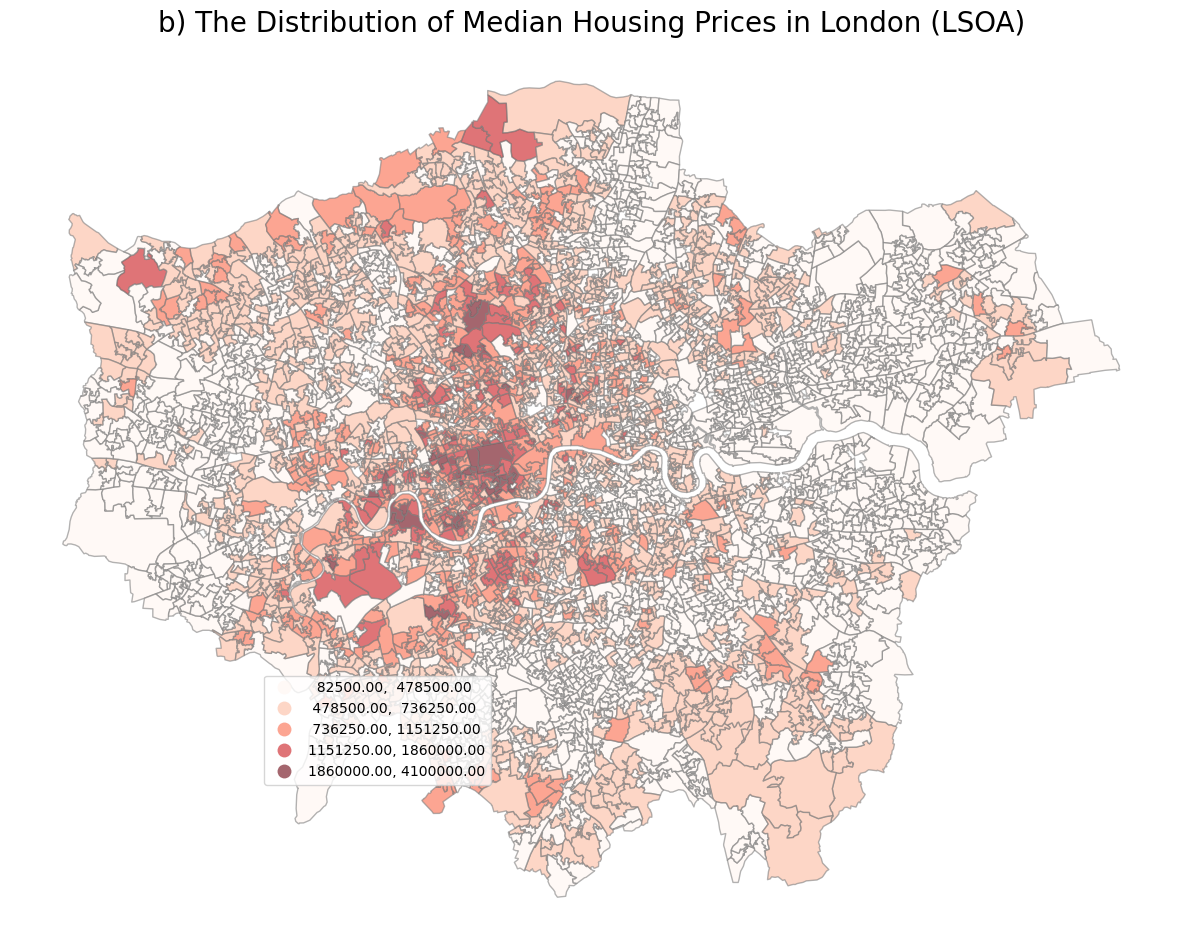

In [61]:
#mapping median housing prices at LSOA level in London
fig, ax = plt.subplots(figsize=(15, 15))

ax.set_aspect('equal')

#natural break 

lsoa_property2.plot(ax=ax,column = "median",cmap="Reds" , edgecolor='grey',scheme = "NaturalBreaks",alpha = 0.6,legend=True)

# this sets the title
ax.set_title("b) The Distribution of Median Housing Prices in London (LSOA)",fontsize= 20)

#customise legend

leg = ax.get_legend()
leg.set_bbox_to_anchor((0.42,0.3))

# this removes the axis
ax.set_axis_off()

print(fig,ax)

#save it

plt.savefig('dist_map.png', dpi=400)

### 3.3. Intersecting London Housing Data with PTAL Grid Values

In [62]:
#intersecting PTAL grid values with house points to get accessibility scores

london_property_gdf2= gpd.sjoin(london_property_gdf2,
                         ptal2, 
                         how="left", 
                         op='intersects').drop(["index_right","lsoa11cd"], axis=1)

london_property_gdf2.head()

BoroughCode     BoroughName    Price  Total Floor Area  Number of Rooms  \
0   E09000001  City of London   746000             61.00              3.0   
1   E09000001  City of London   800000             69.00              3.0   
2   E09000001  City of London  1680000            116.00              3.0   
3   E09000001  City of London   640000             58.00              2.0   
4   E09000001  City of London   645000             78.84              2.0   

   Current Energy Efficiency  Eastings  Northings  \
0                         77    532118     181647   
1                         79    532044     181488   
2                         50    532243     181682   
3                         50    532200     181730   
4                         77    532160     181770   

                        geometry   Age  Property Type S  Property Type D  \
0  POINT (532118.000 181647.000)  21.0                1                1   
1  POINT (532044.000 181488.000)  27.0                1                1   
2  POINT (532243.000 181682.000)  49.0                1                1   
3  POINT (532200.000 181730.000)  49.0                1                1   
4  POINT (532160.000 181770.000)  49.0                1                1   

   Property Type T  Property Type F  LSOA Code  Index of Deprivation Score  \
0                1                2  E01000001                       6.208   
1                1                2  E01000001                       6.208   
2                1                2  E01000001                       6.208   
3                1                2  E01000001                       6.208   
4                1                2  E01000001                       6.208   

   PTAL  
0     8  
1     8  
2     8  
3     8  
4     8

### 3.4. Correlation of Variables (Linearity Assumption)

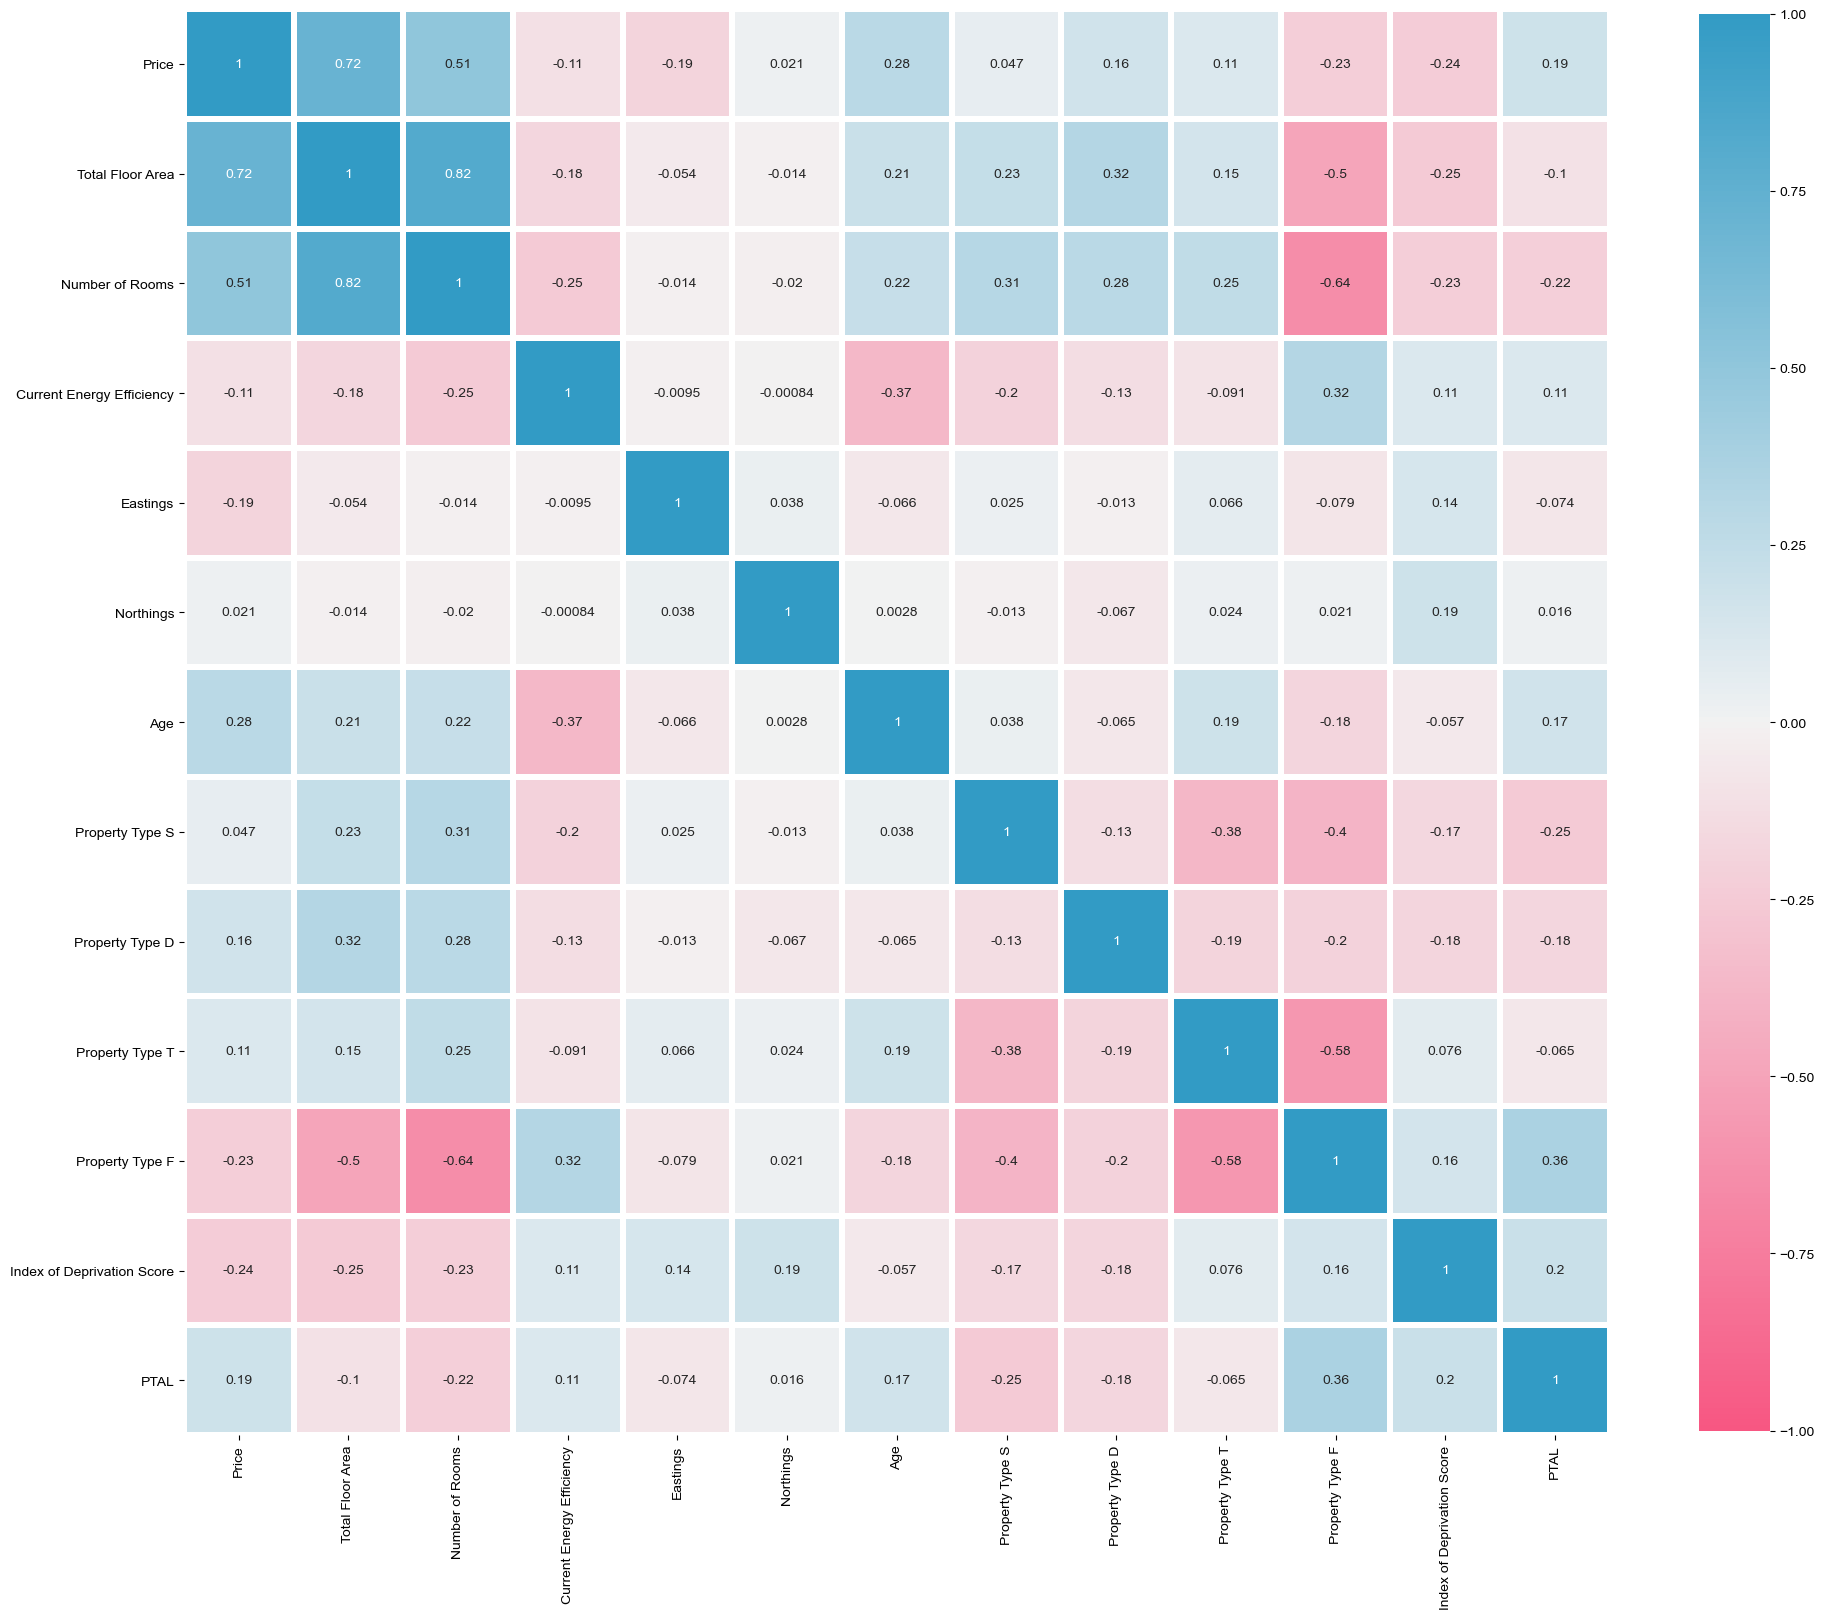

In [63]:
# Compute the correlation matrix
corr = london_property_gdf2.corr()
# Set up the matplotlib figure
plt.figure(figsize=(23,23))
# color map
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, vmax=1, cmap=cmap, vmin=-1, center=0, annot=True,
            square=True, linewidths=3, cbar_kws={"shrink": .8})
plt.yticks(rotation=0)
sns.set(font_scale=1.6)


print(cmap)

plt.savefig('cmap.png', dpi=400)

Figure(1400x1400)


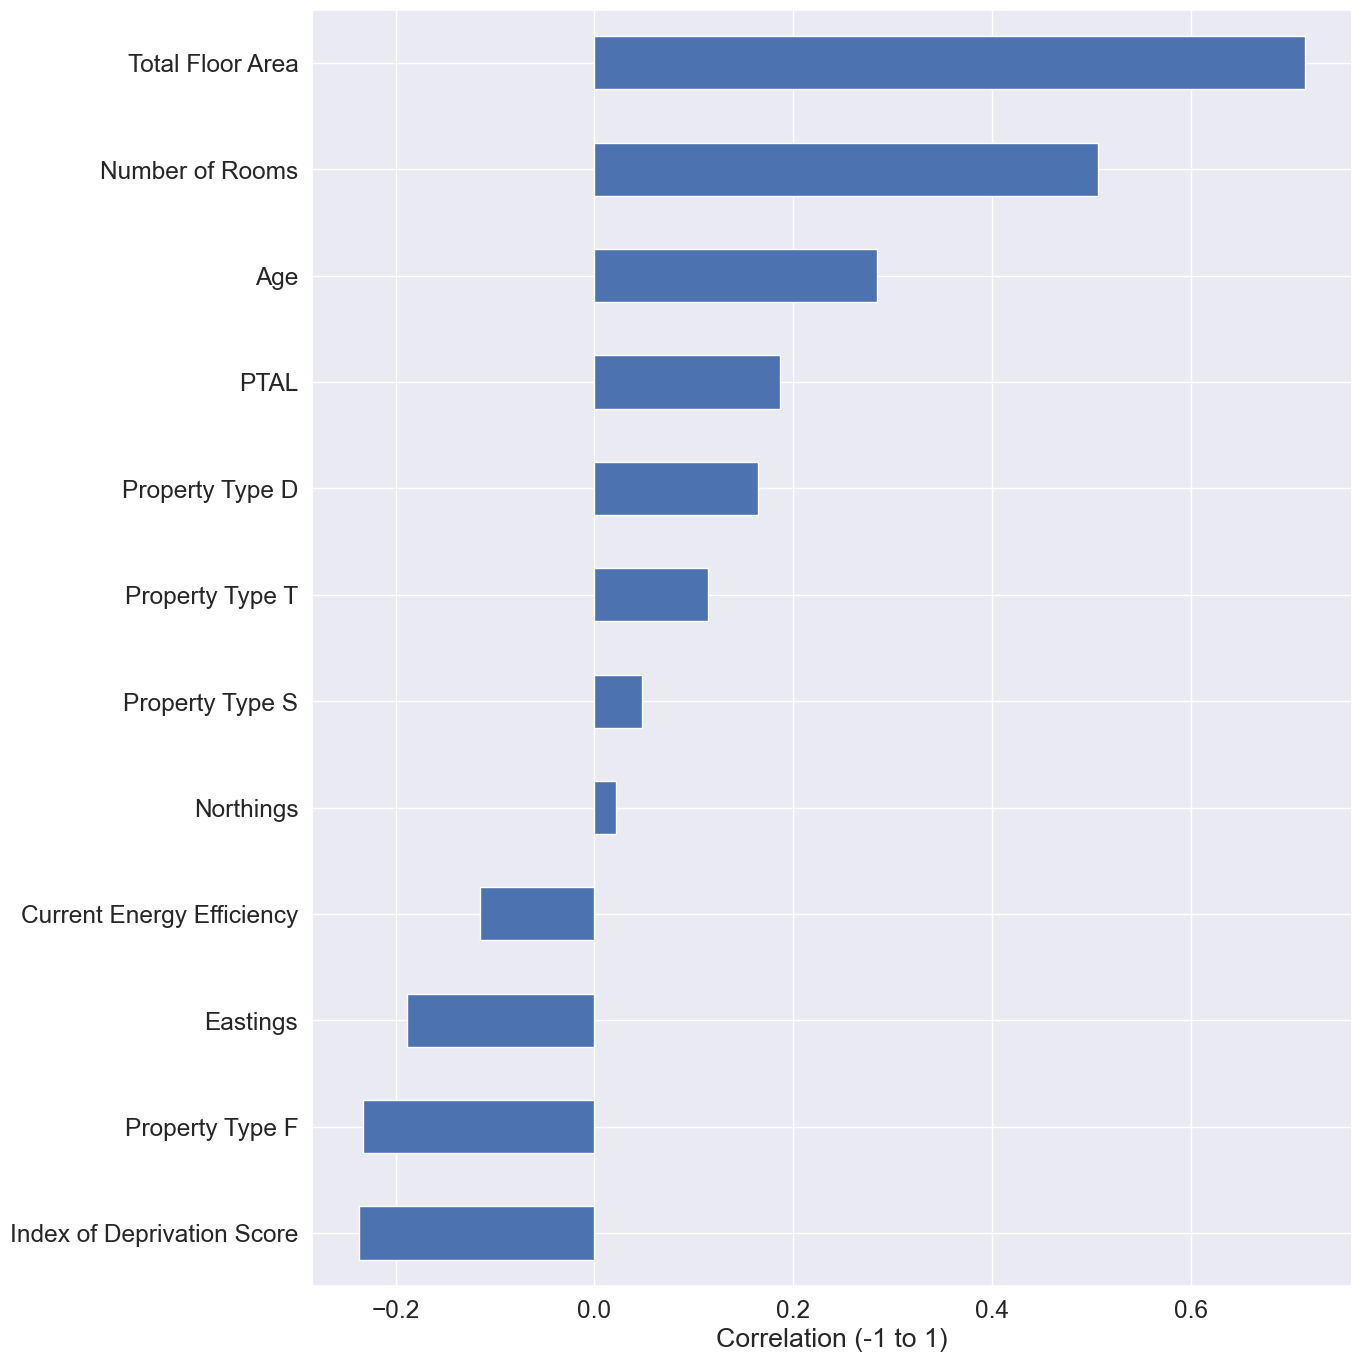

In [65]:
# lets have a look at the correlation in a graph

correlation_graph = plt.figure(figsize=(14,14));
corr["Price"].sort_values(ascending=True)[:-1].plot(kind="barh")
plt.xlabel("Correlation (-1 to 1)")

plt.tight_layout()
sns.set(font_scale=2)

print(correlation_graph)
plt.savefig('correlation.png', dpi=400)

### 3.5. Distribution of Variables (Normality Assumption)

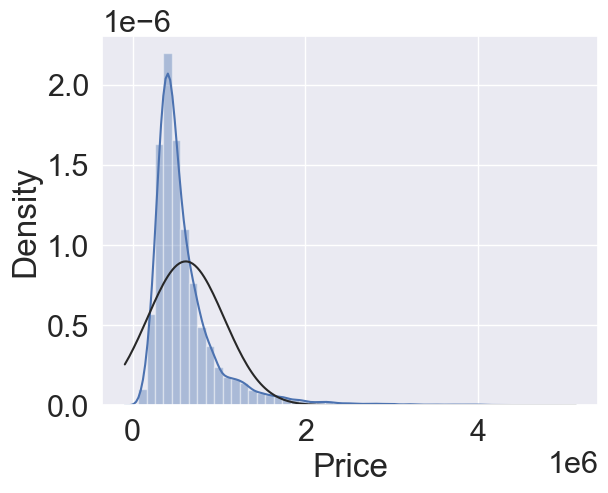

In [66]:
#disribution of housing price (dependent variable)

sns.distplot(london_property_gdf2['Price'], fit=norm)
plt.show()

In [67]:
import scipy.stats

# this runs the shapiro-wilk which tests the null hypothesis the data was drawn from a normal distribution

scipy.stats.shapiro(london_property_gdf2['Price'])

ShapiroResult(statistic=0.6956380605697632, pvalue=0.0)

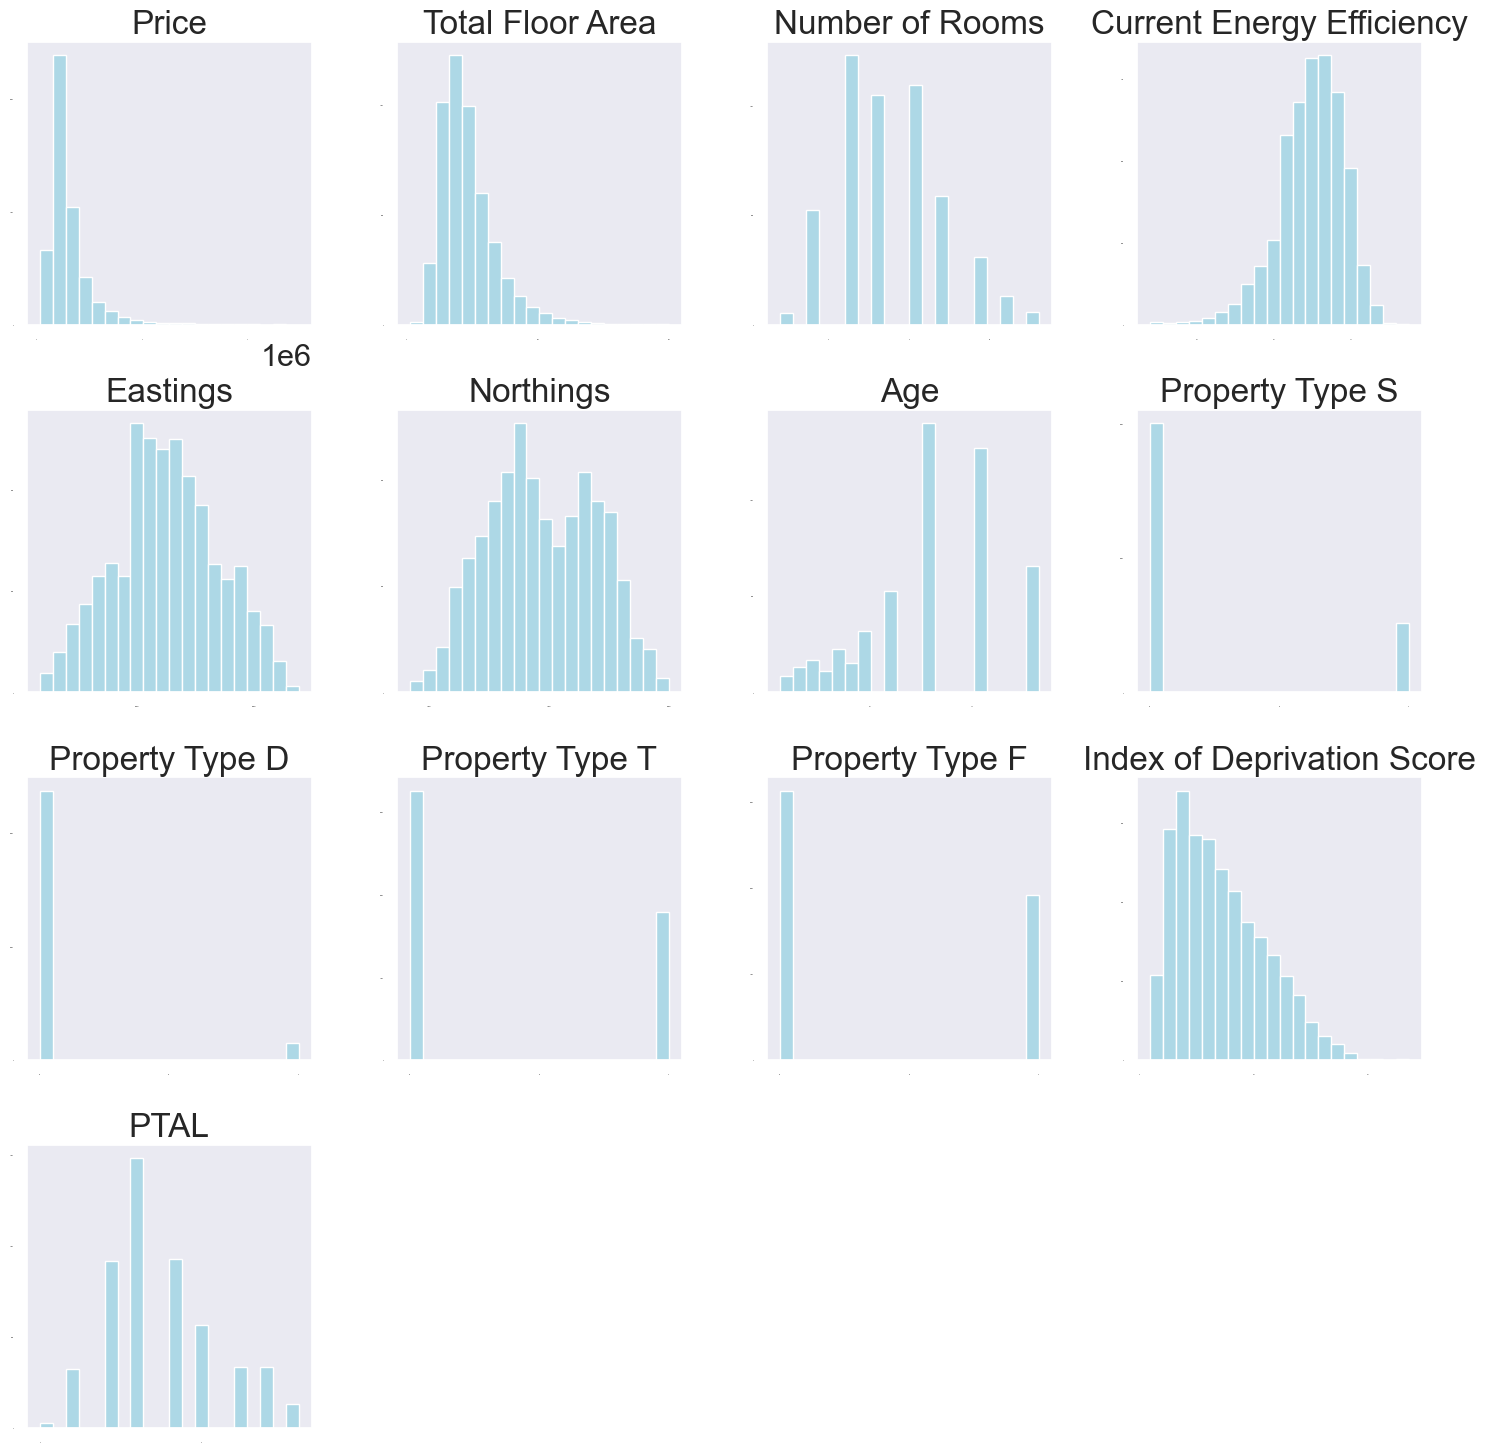

In [68]:
london_property_gdf2.hist(bins=20,
       figsize=(18,18), 
       color='lightblue', 
       xlabelsize=0, 
       ylabelsize=0, 
       grid=False
      )
plt.show()

In [69]:
# pulls out only numeric data columns - in case there were any non-numeric ones
numeric_data = london_property_gdf2.select_dtypes(include=[np.number]).drop(["Property Type S","Property Type D","Property Type T","Property Type F"], axis =1)

numeric_data.head()

Price  Total Floor Area  Number of Rooms  Current Energy Efficiency  \
0   746000             61.00              3.0                         77   
1   800000             69.00              3.0                         79   
2  1680000            116.00              3.0                         50   
3   640000             58.00              2.0                         50   
4   645000             78.84              2.0                         77   

   Eastings  Northings   Age  Index of Deprivation Score  PTAL  
0    532118     181647  21.0                       6.208     8  
1    532044     181488  27.0                       6.208     8  
2    532243     181682  49.0                       6.208     8  
3    532200     181730  49.0                       6.208     8  
4    532160     181770  49.0                       6.208     8

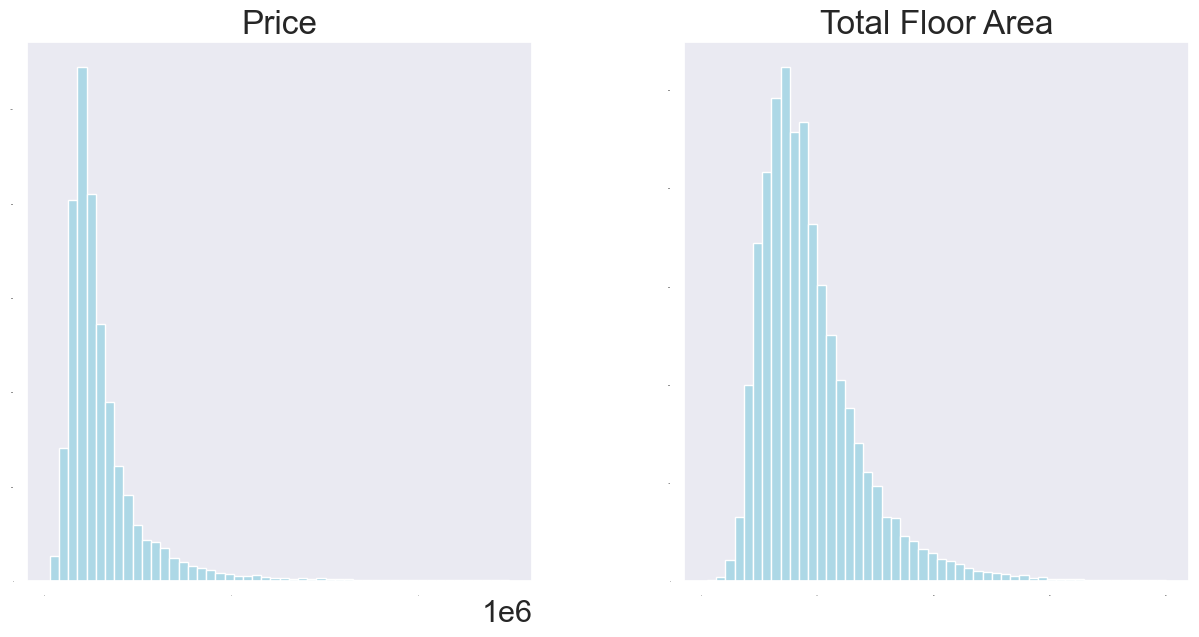

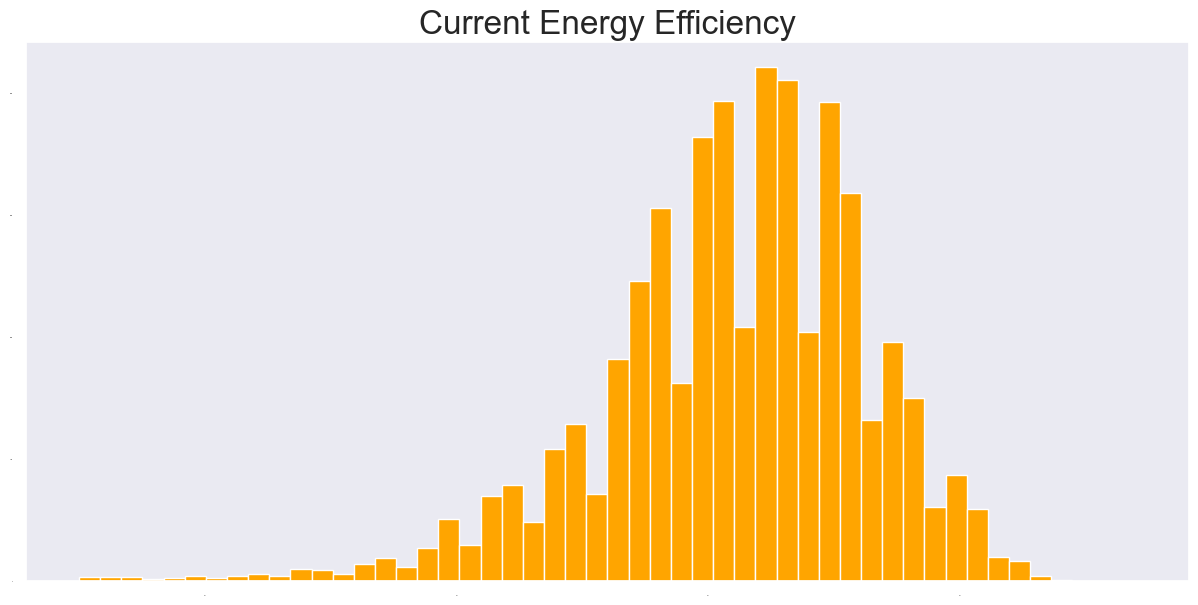

In [70]:
# quantifies the skewedness of the numeric data columns
skewed = london_property_gdf2[numeric_data.columns].apply(lambda london_property_gdf2: skew(london_property_gdf2.dropna().astype(float)))

# and extracts the index of only variables with a skew value of greater than .75
rskewed = skewed[skewed > 0.75 ].index

# and extracts the index of only variables with a skew value of less than -.75
lskewed = skewed[skewed < -0.75 ].index

# and uses this index to map the right skewed variables
london_property_gdf2[rskewed].hist(bins=50, figsize=(15, 7), color='lightblue', xlabelsize=0, ylabelsize=0, grid=False)
plt.show()

# and uses this index to map the left skewed variables
london_property_gdf2[lskewed].hist(bins=50, figsize=(15, 7), color='orange', xlabelsize=0, ylabelsize=0, grid=False)
plt.show()


### 3.6. Transforming and Scaling Variables

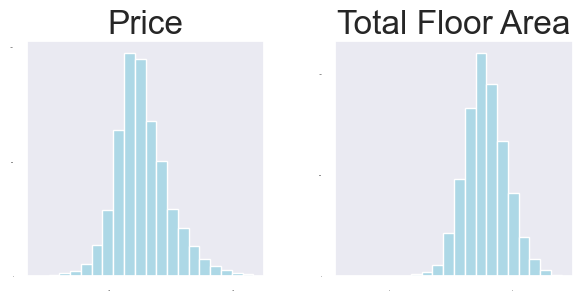

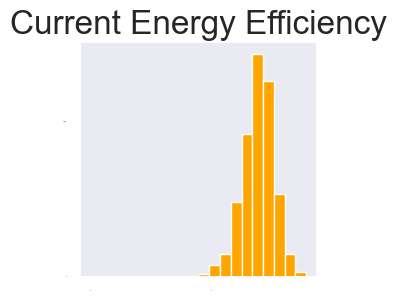

In [71]:
# log-transforms the highly right skewed variables of the dataset
london_property_gdf2[rskewed] = np.log(london_property_gdf2[rskewed])

# log-transforms the left skewed reflected variables of the dataset 
london_property_gdf2[lskewed] = np.log1p(np.max(london_property_gdf2[lskewed])-london_property_gdf2[lskewed])

# now plot again the variables after their log transformation
london_property_gdf2[rskewed].hist(bins=20,figsize=(15,7), color='lightblue', xlabelsize=0, ylabelsize=0, grid=False, layout=(2,4))
plt.show()

# now plot again the variables after their log transformation
london_property_gdf2[lskewed].hist(bins=20,figsize=(15,7), color='orange', xlabelsize=0, ylabelsize=0, grid=False, layout=(2,4))
plt.show()

In [72]:
london_property_gdf2.head()

BoroughCode     BoroughName      Price  Total Floor Area  Number of Rooms  \
0   E09000001  City of London  13.522481          4.110874              3.0   
1   E09000001  City of London  13.592367          4.234107              3.0   
2   E09000001  City of London  14.334304          4.753590              3.0   
3   E09000001  City of London  13.369223          4.060443              2.0   
4   E09000001  City of London  13.377006          4.367420              2.0   

   Current Energy Efficiency  Eastings  Northings  \
0                   2.890372    532118     181647   
1                   2.772589    532044     181488   
2                   3.806662    532243     181682   
3                   3.806662    532200     181730   
4                   2.890372    532160     181770   

                        geometry   Age  Property Type S  Property Type D  \
0  POINT (532118.000 181647.000)  21.0                1                1   
1  POINT (532044.000 181488.000)  27.0                1                1   
2  POINT (532243.000 181682.000)  49.0                1                1   
3  POINT (532200.000 181730.000)  49.0                1                1   
4  POINT (532160.000 181770.000)  49.0                1                1   

   Property Type T  Property Type F  LSOA Code  Index of Deprivation Score  \
0                1                2  E01000001                       6.208   
1                1                2  E01000001                       6.208   
2                1                2  E01000001                       6.208   
3                1                2  E01000001                       6.208   
4                1                2  E01000001                       6.208   

   PTAL  
0     8  
1     8  
2     8  
3     8  
4     8

In [73]:
# set X and y
numeric_data2 = london_property_gdf2.select_dtypes(include=[np.number])
X=numeric_data2[numeric_data2.columns[numeric_data2.columns!='Price']]
y=numeric_data2['Price']
print (X.shape)
print (y.shape)

(50432, 12)
(50432,)


In [74]:

scaler = StandardScaler()
scaled_X = pd.DataFrame(scaler.fit_transform(X),columns=X.columns)

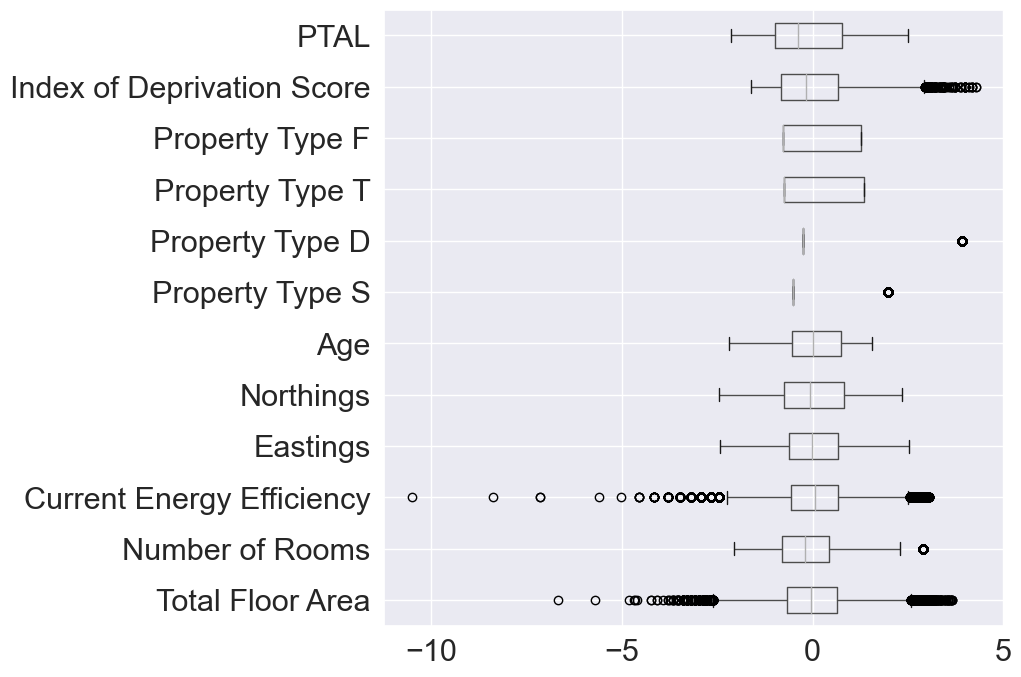

In [75]:
scaled_X.boxplot(vert=False,figsize=(8,8))
plt.show()

In [76]:
### split the dataset
(X_train, X_test, y_train, y_test) = train_test_split(scaled_X, y, train_size=0.7)#, random_state=1)


In [77]:
X_train.head()

Total Floor Area  Number of Rooms  Current Energy Efficiency  Eastings  \
8249           0.005891         0.426046                   1.437430  1.386573   
45698         -0.050200         0.426046                   0.434513  0.626645   
25459          1.466299         1.667316                  -0.225613 -2.142319   
3120           0.435388         0.426046                  -1.069010  1.711885   
9473           1.961952         2.908585                  -0.122112  0.380485   

       Northings       Age  Property Type S  Property Type D  Property Type T  \
8249   -1.230946  0.004903         1.973426        -0.254598        -0.740842   
45698   1.303101  0.004903         1.973426        -0.254598        -0.740842   
25459   0.375210  0.004903        -0.506733         3.927768        -0.740842   
3120   -0.377109 -1.762336        -0.506733         3.927768        -0.740842   
9473   -0.859567  0.747441         1.973426        -0.254598        -0.740842   

       Property Type F  Index of Deprivation Score      PTAL  
8249         -0.783634                    0.597140  0.188483  
45698        -0.783634                   -0.215030 -0.392295  
25459        -0.783634                   -0.207554 -0.392295  
3120         -0.783634                   -0.666593 -0.973073  
9473         -0.783634                   -0.060321  1.350040

## 4. Analysis

### 4.1. Function for Models

*Predictive Model function code above was adapted from Predicting Housing Prices using Cross Validation and Grid Search in Regression Models blog of Yohan Jeong

https://yjeong5126.medium.com/predicting-housing-prices-in-melbourne-e3d5f49abf20



*Feature Importance function code above was adapted from Random Forest Feature Importance Plot training in Analyse Up

https://www.analyseup.com/learn-python-for-data-science/python-random-forest-feature-importance-plot.html

In [198]:
#function for fitting and getting results from models

def Predictive_Model(estimator):

#fit the model that we provide with estimator argument

    estimator.fit(X_train, y_train)
    prediction = estimator.predict(X_test)

#print metrics
    print('R_squared:', metrics.r2_score(y_test, prediction))
    print('MSE:',metrics.mean_squared_error(y_test, prediction))
    print ('MAE: ',mean_absolute_error(y_test,estimator.predict(X_test)))
    
#plot actual and predicted values

    plt.figure(figsize=(10,5))
    sns.distplot(y_test, hist=True, kde=False)
    sns.distplot(prediction, hist=True, kde=False)
    plt.legend(labels=['Actual Values of Price', 'Predicted Values of Price'],fontsize=14)
    
    
# function for feature importance graph

def Feature_Importance(importance,names,model_type):

#Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
#Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

#Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

#Define size of bar plot
    plt.figure(figsize=(10,8))
#Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
#Add chart labels72
    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

### 4.2. Base Models

#### 4.2.1. Linear Regression

R_squared: 0.6857247645017666
MSE: 0.09210990421890963
MAE:  0.22680356027423093


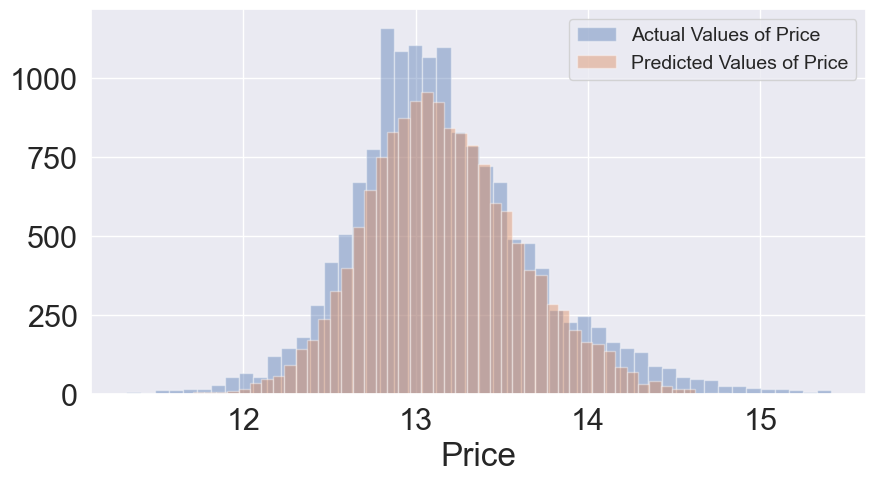

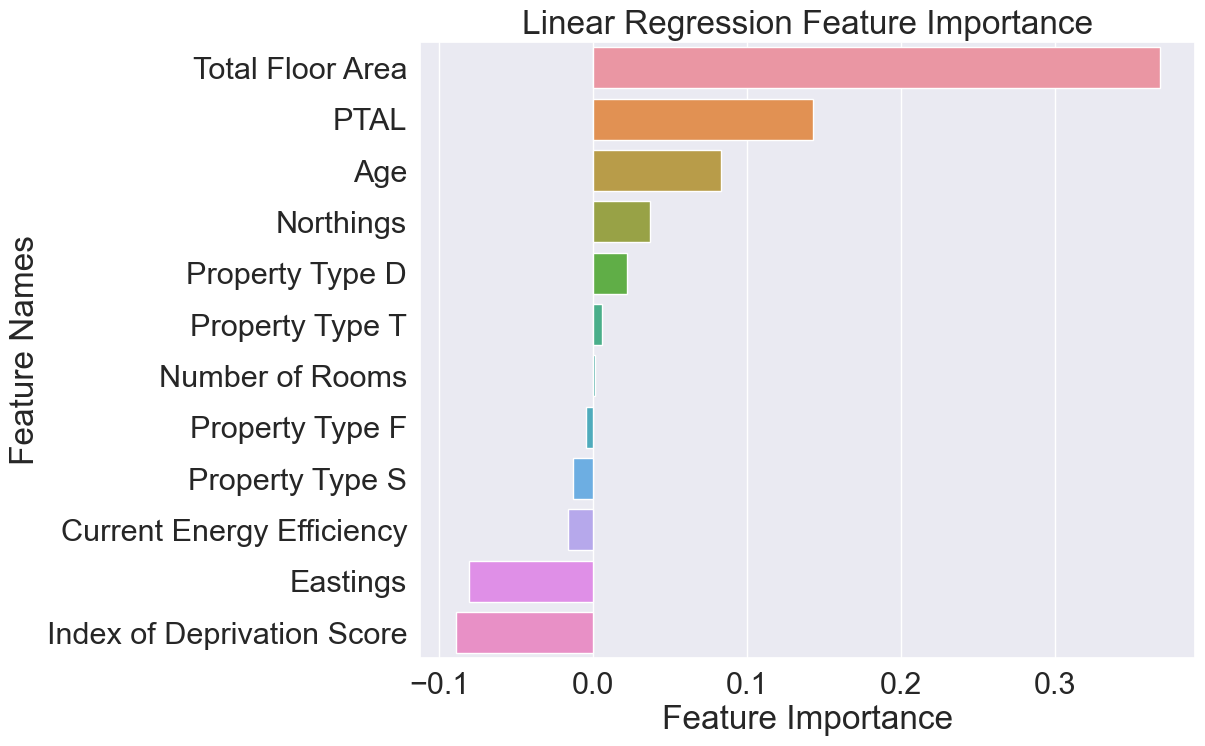

In [199]:
#linear regression

lr = linear_model.LinearRegression()

#apply function for prediction

Predictive_Model(lr)

#apply function for feature importance graph

Feature_Importance(lr.coef_,X_train.columns, "Linear Regression")


#### 4.2.2. K-Nearest Neighbors

R_squared: 0.7974581804643313
MSE: 0.05936232159106601
MAE:  0.1709910653346786


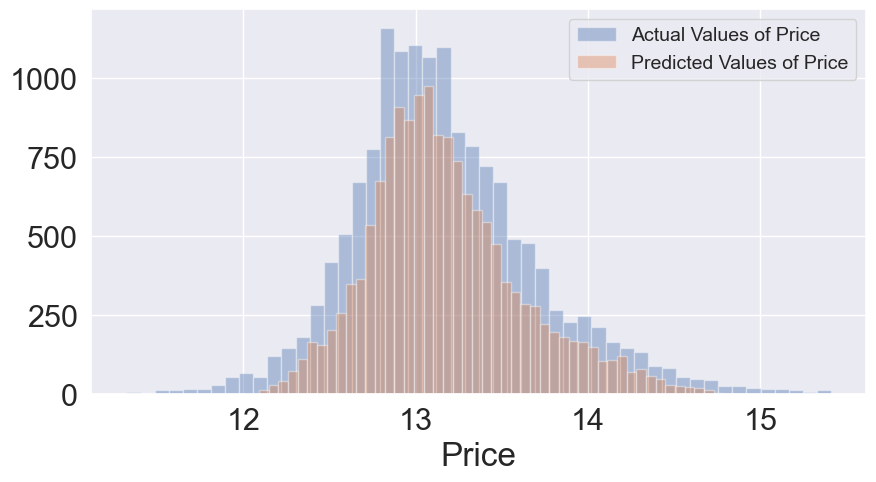

In [200]:
#knearest neighbor

knn = KNeighborsRegressor(n_neighbors=25)

#apply function for prediction

Predictive_Model(knn)


#### 4.2.3. Random Forest

R_squared: 0.8580792968539607
MSE: 0.041595076216355185
MAE:  0.13879010498177835


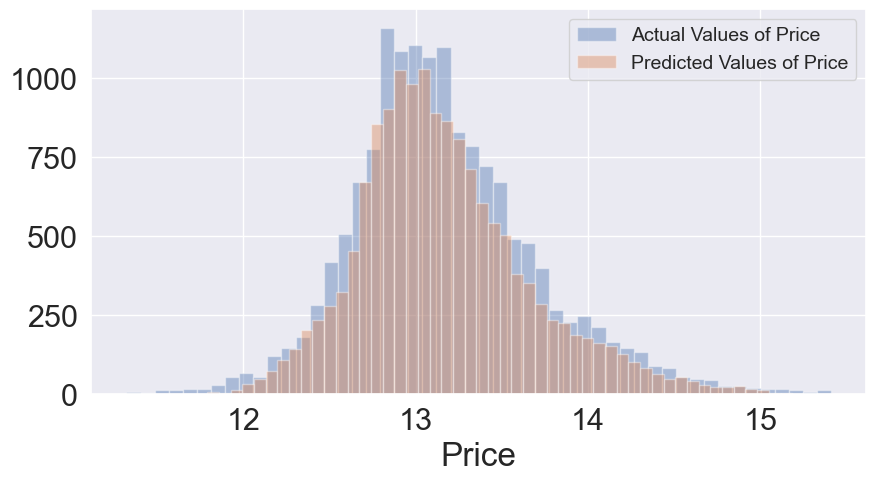

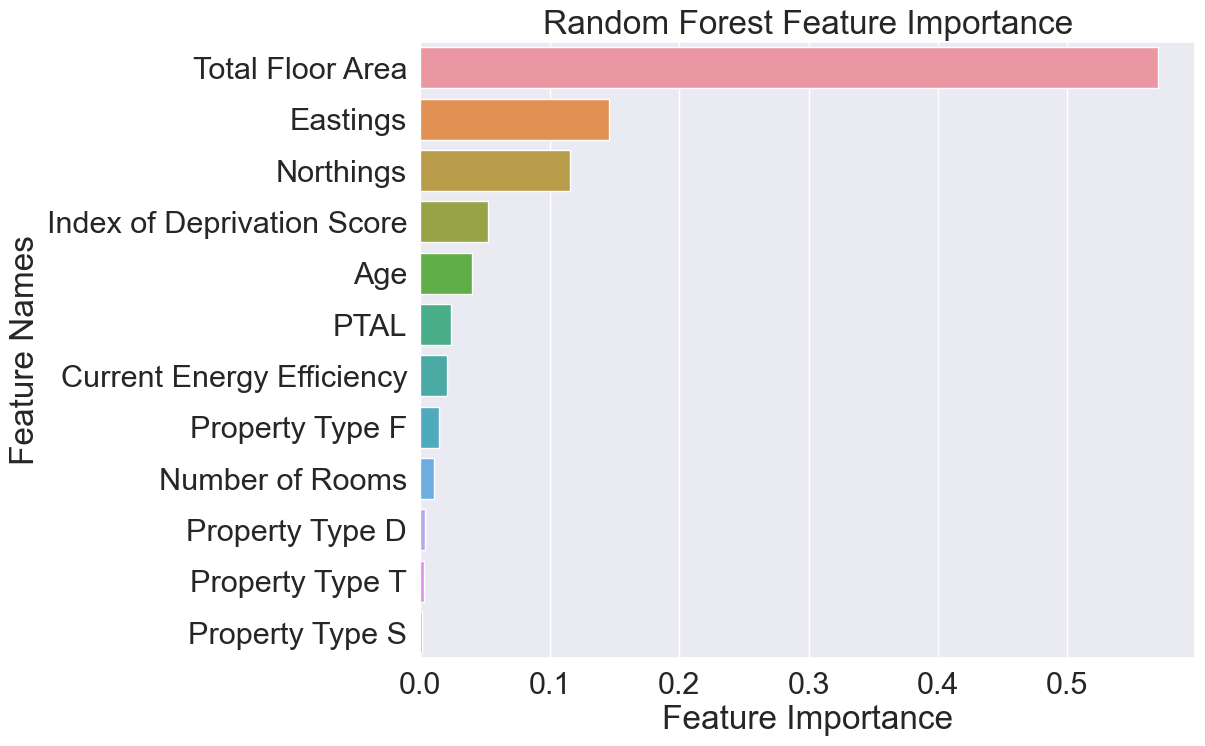

In [201]:
#random forest

rf = RandomForestRegressor()

#apply function for prediction

Predictive_Model(rf)

#apply function for feature importance

Feature_Importance(rf.feature_importances_, X_train.columns, "Random Forest")


### 4.3. Hyperparameter Tuning

#### 4.3.1. Lasso Regularisation with Grid Search
**The code is retrieved from https://sqlrelease.com/hyperparameter-tuning-using-gridsearchcv-and-randomizedsearchcv-in-python

In [195]:

# Let's create a list of alpha values which is a hyperparameter for Lasso regression
alphas = np.array([0.01, 
                    0.001, 
                    0.0001, 
                    0.0002, 
                    0.0003, 
                    0.0004, 
                    0.0005,
                    0.0006,
                    0.0007,
                    0.0008,
                    0.0009])
 
# Create a parameter grid dictionary with hyperparameter values
paramgrid = {'alpha': alphas}
 
# Instantiate a Lasso regularized model 
model = Lasso()
 
# Instantiate the RandomizedSearchCV method
grid = RandomizedSearchCV(estimator = model, param_distributions = paramgrid,n_iter = 100, cv = 10, verbose=2, random_state=35, n_jobs = -1)
 
# Fit the data into model using RandomizedSearchCV
grid.fit(X_train, y_train)
 
# Get the best score of hyperparameter alpha for Lasso regression and print it
print("The best hyperparameter value for alpha for Lasso regression is: {0}".format(grid.best_estimator_.alpha))
print('\n')

Fitting 10 folds for each of 11 candidates, totalling 110 fits
The best hyperparameter value for alpha for Lasso regression is: 0.0001




R_squared: 0.6857295299798626
MSE: 0.0921085075204702
MAE:  0.226794530422327


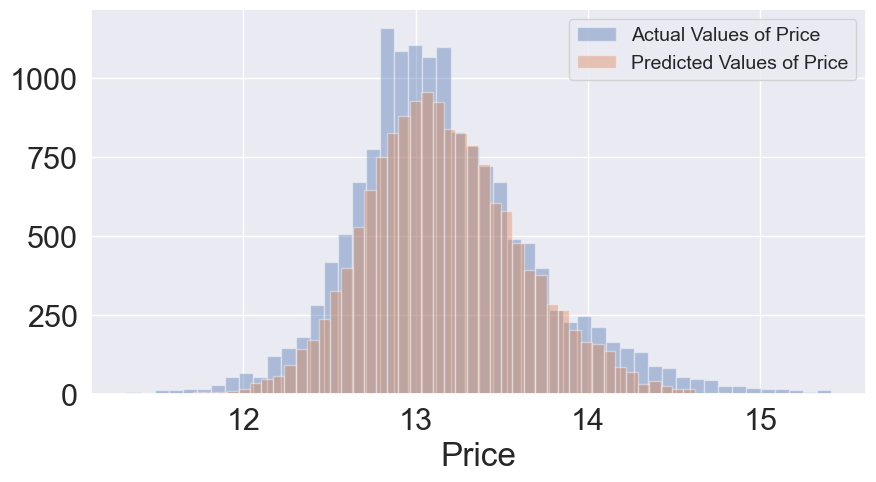

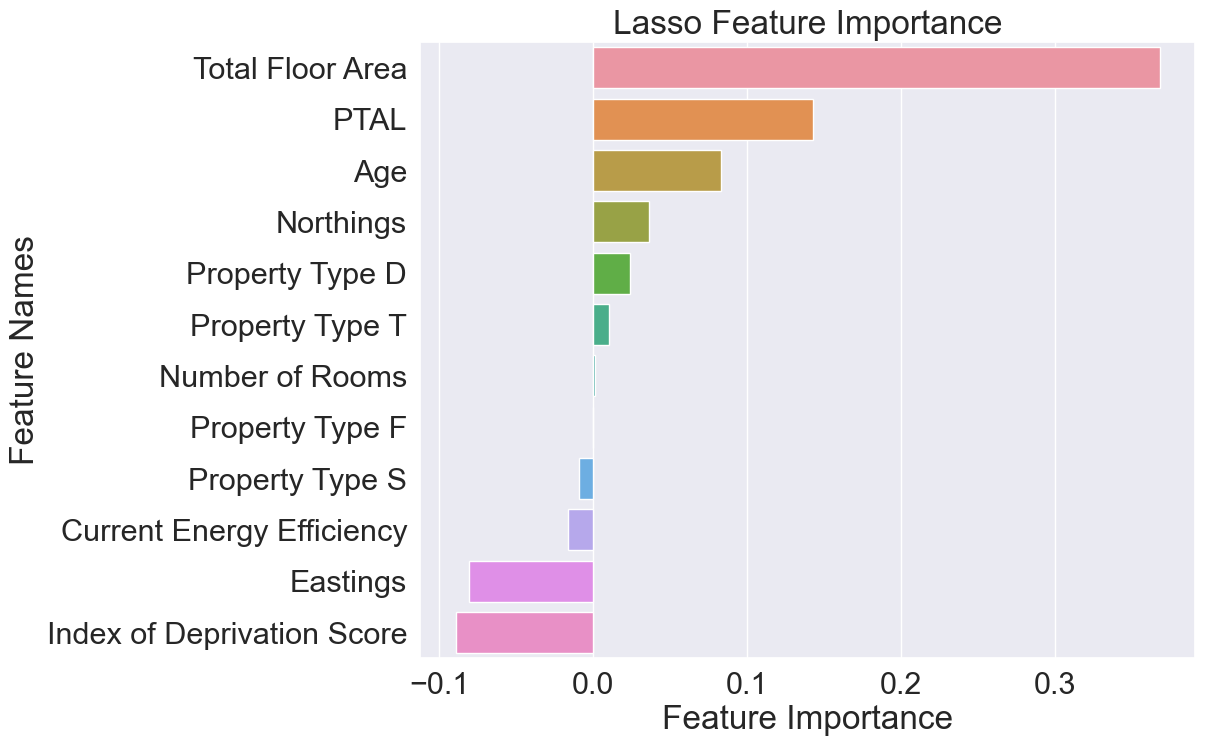

In [202]:
#fitting lasso model with optimal alpha

lasso = linear_model.Lasso(alpha=0.0001)

#apply prediction function

Predictive_Model(lasso)

#apply feature importance function

Feature_Importance(lasso.coef_,X_train.columns, "Lasso")


#### 4.3.2. Principal Component  (just for testing)

In [125]:
#PCA fitting
n=int((scaled_X.shape[1]))
pca = PCA(n_components=n)
X_proj = pca.fit_transform(scaled_X)
principalComponents = X_proj
principalDf = pd.DataFrame(data = principalComponents)
pcadf=principalDf

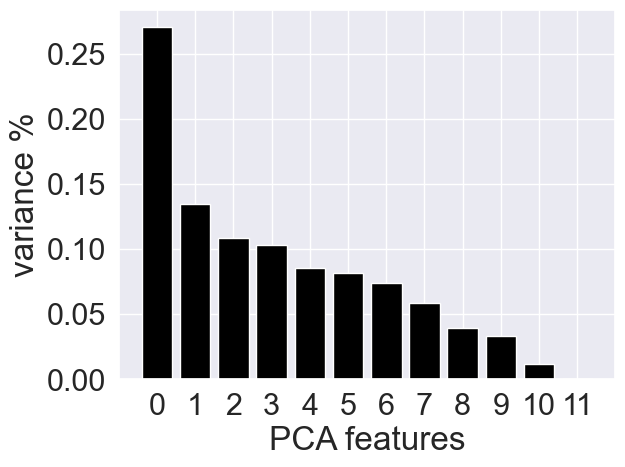

In [126]:
#variance plotting
response=list(range(n))
plt.bar(response, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(response)
plt.show()

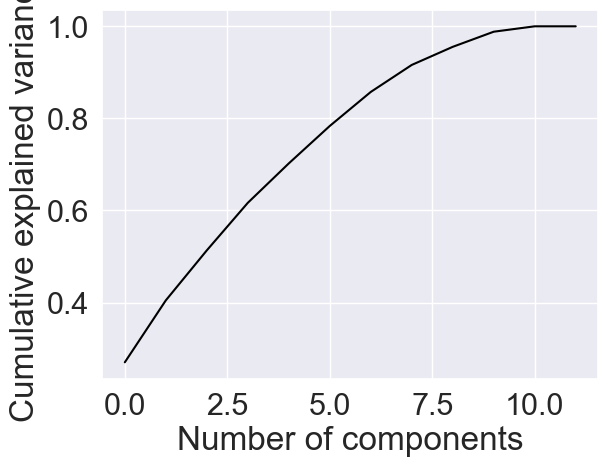

1.0000000000000002

In [127]:
#cumulative explained variance plotting

response=list(range(n))
pcadf_p=pcadf[response]
plt.plot(np.cumsum(pca.explained_variance_ratio_),color='black')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()
np.sum(pca.explained_variance_ratio_)

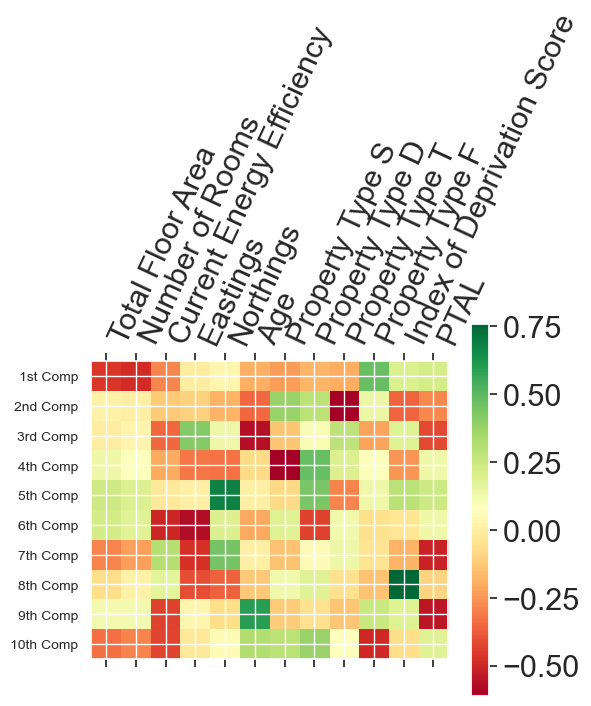

In [128]:
#plotting PCA components

plt.matshow(pca.components_[:10],cmap='RdYlGn')
plt.yticks([0,1,2,3,4,5,6,7,8,9],['1st Comp','2nd Comp','3rd Comp','4th Comp','5th Comp','6th Comp','7th Comp','8th Comp','9th Comp','10th Comp'],fontsize=10)
plt.colorbar()
plt.xticks(range(len(X.columns)),X.columns,rotation=65,ha='left')
plt.tight_layout()
plt.show()


In [129]:
#PCA fitting with 10 components

pca = PCA(n_components=10,random_state=42)
#Scale and transform data to get Principal Components

Xtrain_reduced = pca.fit_transform(X_train)
Xtest_reduced = pca.transform(X_test)
regrpca6 = linear_model.LinearRegression()
# Train the model using the principal components of the transformed training sets
regrpca6.fit(Xtrain_reduced, y_train)
# Make predictions using the principal components of the transformed testing set
y_pred = regrpca6.predict(Xtest_reduced)

In [130]:
# Explained variance score: 1 is perfect prediction
print('R2 score: %.2f' % r2_score(y_test, y_pred))
print('MSE:',metrics.mean_squared_error(y_test, y_pred))

R2 score: 0.65
MSE: 0.10145038264508531


#### 4.3.3. K-nearest Neighbor (Grid Search)

In [ ]:
# function for grid search 

## function is retrieveed from https://yjeong5126.medium.com/predicting-housing-prices-in-melbourne-e3d5f49abf20

def GridSearch(estimator, Features, Target, param_grid):
    for key, value in scoring.items():
        grid = GridSearchCV(estimator, param_grid, cv=10, scoring=value)
        grid.fit(Features,Target)
        print(key)
        print('The Best Parameter:', grid.best_params_)
        if grid.best_score_ > 0:
            print('The Score:', grid.best_score_)
        else:
            print('The Score:', abs(grid.best_score_))
        print()
                  

In [112]:
#knn regression

knn1 = KNeighborsRegressor()
from sklearn.model_selection import GridSearchCV
k_range = list(range(1, 25))
weight_options = ['uniform', 'distance']
param_grid = dict(n_neighbors=k_range, weights=weight_options)
  
# defining parameter range
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy', return_train_score=False)
  
# fitting the model for grid search
grid_search=grid.fit(X_train, y_train)

print(grid.best_score_)
print(grid.best_params_)

nan
{'n_neighbors': 1, 'weights': 'uniform'}


In [133]:
#fitting knn with optimal parameters

params = {
    'n_neighbors': [13],  #'n_neighbors': [3,4,5,6,7,8,9,10,11,12], Number of neighbor points to consider for prediction
    'weights': ['uniform'],  #'weights': ['uniform', 'distance'], weight function used in prediction
    'p': [1]  #'p': [1,2] # p=1 compute manhattan distance, p=2 compute euclidean distance
    }

knn = KNeighborsRegressor()
rs = GridSearchCV(estimator=knn, param_grid=params, cv=10, n_jobs=-1, scoring='neg_mean_squared_error')
rs.fit(X_train, y_train)
print(rs.best_estimator_)
knn = rs.best_estimator_
knn.fit(X_train, y_train)
pred_knn_hype = knn.predict(X_test)

#result printing

print('-'*30)
r2 = r2_score(y_test, pred_knn_hype)
print('R2: ', r2)
err = mean_squared_error(y_test, pred_knn_hype)
print('Mean Squared Error: ', err)
knn_reg = ('KNN', r2, err)

KNeighborsRegressor(n_neighbors=13, p=1)
------------------------------
R2:  0.8084055293235475
Mean Squared Error:  0.05615379880283292


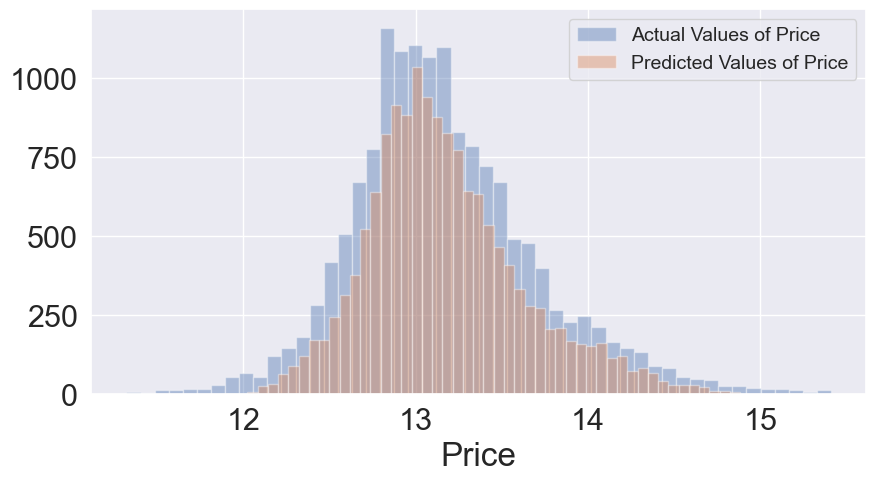

In [204]:
#plot actual and predicted values

plt.figure(figsize=(10,5))
sns.distplot(y_test, hist=True, kde=False)
sns.distplot(pred_knn_hype, hist=True, kde=False)
plt.legend(labels=['Actual Values of Price', 'Predicted Values of Price'],fontsize=14)
    

#### 4.3.4. Random Forest (Randomized Search

**The code is retrieved from https://www.kaggle.com/code/arjunprasadsarkhel/simple-random-forest-with-hyperparameter-tuning

In [115]:
##finding optimal paramaters

n_estimators = [5,20,50,100] # number of trees in the random forest
max_features = ['auto', 'sqrt'] # number of features in consideration at every split
max_depth = [int(x) for x in np.linspace(10, 120, num = 12)] # maximum number of levels allowed in each decision tree
min_samples_split = [2, 6, 10] # minimum sample number to split a node
min_samples_leaf = [1, 3, 4] # minimum sample number that can be stored in a leaf node
bootstrap = [True, False] # method used to sample data points

random_grid = {'n_estimators': n_estimators,

'max_features': max_features,

'max_depth': max_depth,

'min_samples_split': min_samples_split,

'min_samples_leaf': min_samples_leaf,

'bootstrap': bootstrap}

In [116]:
#random forest 

rf = RandomForestRegressor()

In [117]:
#randomised search
rf_random = RandomizedSearchCV(estimator = rf,param_distributions = random_grid,
               n_iter = 100, cv = 5, verbose=2, random_state=35, n_jobs = -1)

In [118]:
#fitting random forest

rf_random.fit(X_train, y_train)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      120],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 3, 4],
                                        'min_samples_split': [2, 6, 10],
                                        'n_estimators': [5, 20, 50, 100]},
                   random_state=35, verbose=2)

In [119]:
#printing best parameters

print ('Random grid: ', random_grid, '\n')

print ('Best Parameters: ', rf_random.best_params_, ' \n')

Random grid:  {'n_estimators': [5, 20, 50, 100], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120], 'min_samples_split': [2, 6, 10], 'min_samples_leaf': [1, 3, 4], 'bootstrap': [True, False]} 

Best Parameters:  {'n_estimators': 100, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 120, 'bootstrap': True}  



In [120]:
#fitting the model again with best parameters

randmf = RandomForestRegressor(n_estimators = 100, min_samples_split = 6, min_samples_leaf= 1, max_features = 'auto', max_depth= 120, bootstrap=True) 
randmf.fit( X_train, y_train) 

RandomForestRegressor(max_depth=120, max_features='auto', min_samples_split=6)

R_squared: 0.8596841472655741
MSE: 0.04112471584110945
MAE:  0.13820293032041767


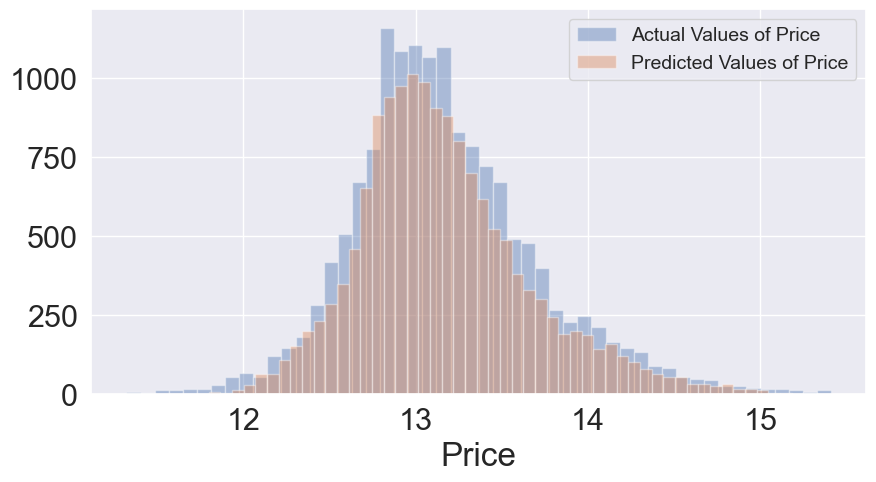

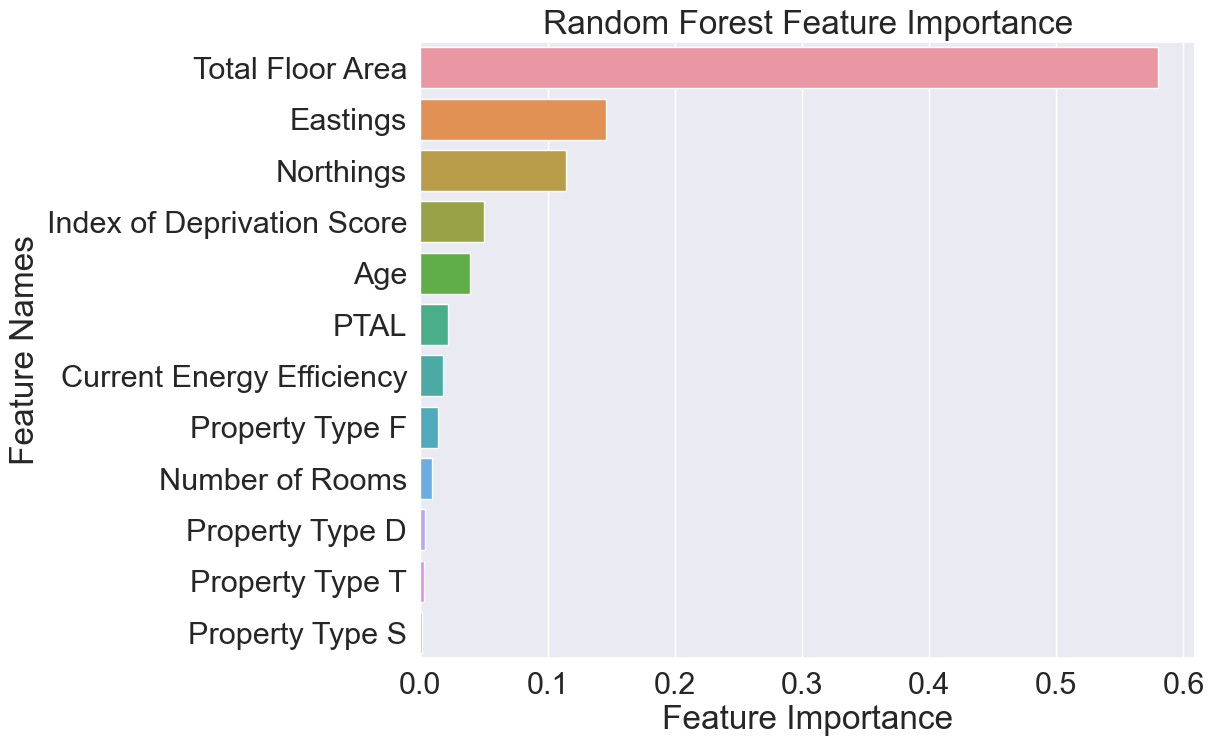

In [205]:
#applying predidiction function

Predictive_Model(randmf)

#applying feature importance function to plot actual vs predicted and feature importance graph
Feature_Importance(randmf.feature_importances_, X_train.columns, "Random Forest")
